# Grid navigation for different input representations

In [1]:
colab = False

if colab:
    from google.colab import drive
    drive.mount('/content/gdrive')
    !git clone https://github.com/deepmind/pycolab.git
    !git clone https://github.com/nicoladainese96/RelationalDeepRL.git
    !pip install pycolab

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
if colab: 
    import sys
    sys.path.insert(0, 'RelationalDeepRL')

from RelationalModule import ActorCritic, ControlActorCritic, CoordActorCritic, OheActorCritic
from RelationalModule import GatedActorCritic, MultiplicativeActorCritic
from Utils import train_agent_sandbox as train
from Utils import test_env, utils, plot
from importlib import reload

# Multiplicative Agent

In [13]:
# Variable parameters
X = 10
Y = 10
initial = [0,0]
goal = [4,4]
MAX_STEPS = 200

game_params = dict(x=X, y=Y, initial=initial, goal=goal, max_steps=MAX_STEPS, 
                   greyscale_state=True, return_ohe=True)

In [14]:
multi_HPs = torch.load("Results/Sandbox/Supervised/best_HP_S_best-multiconvnet_FQXZ")
multi_HPs['plug_off'] = True
multi_HPs

{'out_channels': [12],
 'max_pool_size': 2,
 'n_features': 32,
 'info_channels': 8,
 'mask_channels': 8,
 'hidden_channels': 6,
 'residual_hidden_dim': 64,
 'n_residual_layers': 3,
 'plug_off': True}

In [15]:
HPs = dict(lr=5e-4, gamma=0.99, TD=True, twin=True, tau=0.1, n_steps=5, H=1e-3, 
           radam=False, linear_size = X+2, **multi_HPs)

if colab or torch.cuda.is_available:
    HPs['device'] = 'cuda'
else:
    HPs['device'] = 'cpu'
    
print("Using device "+HPs['device'])

# Relational Agent
agent = MultiplicativeActorCritic.MultiplicativeA2C(action_space = 4, **HPs)

Using device cuda


In [16]:
# see if everything works before starting the real training cycle
env = test_env.Sandbox(**game_params)
rewards, log_probs, distributions, states, done, bootstrap = train.play_episode(agent, env, max_steps=MAX_STEPS)

In [17]:
print("rewards: ", rewards.shape)
print("log_probs: ", len(log_probs))
print("distributions: ", len(distributions))
print("states: ", states.shape)
print("done: ", done.shape)
print("bootstrap: ", bootstrap.shape)

rewards:  (30,)
log_probs:  30
distributions:  30
states:  (31, 3, 12, 12)
done:  (30,)
bootstrap:  (30,)


In [18]:
agent.update(rewards, log_probs, distributions, states, done, bootstrap)

(0.37977030873298645, 0.38842296600341797, -0.0003430289216339588)

In [ ]:
%%time
results = train.train_sandbox(trained_agent, game_params, n_episodes = 5000,
                              max_steps=MAX_STEPS, return_agent=True, random_init=True)

Episode 10 - reward: 0.60 - steps to solve: 85.50
Episode 20 - reward: 0.60 - steps to solve: 99.40
Episode 30 - reward: 0.60 - steps to solve: 89.00
Episode 40 - reward: 0.60 - steps to solve: 90.80
Episode 50 - reward: 0.80 - steps to solve: 45.70
Episode 60 - reward: 0.50 - steps to solve: 104.30
Episode 70 - reward: 0.90 - steps to solve: 40.70
Episode 80 - reward: 0.20 - steps to solve: 167.90
Episode 90 - reward: 0.10 - steps to solve: 180.80
Episode 100 - reward: 0.20 - steps to solve: 160.70
Episode 110 - reward: 0.30 - steps to solve: 141.30
Episode 120 - reward: 0.40 - steps to solve: 125.30
Episode 130 - reward: 0.70 - steps to solve: 74.00
Episode 140 - reward: 0.50 - steps to solve: 107.60
Episode 150 - reward: 0.00 - steps to solve: 200.00
Episode 160 - reward: 0.00 - steps to solve: 200.00
Episode 170 - reward: 0.10 - steps to solve: 180.20
Episode 180 - reward: 0.10 - steps to solve: 180.40
Episode 190 - reward: 0.10 - steps to solve: 184.00
Episode 200 - reward: 0.20 -

Episode 1580 - reward: 0.10 - steps to solve: 184.90
Episode 1590 - reward: 0.10 - steps to solve: 180.50
Episode 1600 - reward: 0.00 - steps to solve: 200.00
Episode 1610 - reward: 0.00 - steps to solve: 200.00
Episode 1620 - reward: 0.00 - steps to solve: 200.00
Episode 1630 - reward: 0.10 - steps to solve: 180.10
Episode 1640 - reward: 0.00 - steps to solve: 200.00
Episode 1650 - reward: 0.10 - steps to solve: 180.40
Episode 1660 - reward: 0.00 - steps to solve: 200.00
Episode 1670 - reward: 0.00 - steps to solve: 200.00
Episode 1680 - reward: 0.00 - steps to solve: 200.00
Episode 1690 - reward: 0.00 - steps to solve: 200.00
Episode 1700 - reward: 0.20 - steps to solve: 160.80
Episode 1710 - reward: 0.00 - steps to solve: 200.00
Episode 1720 - reward: 0.10 - steps to solve: 180.40
Episode 1730 - reward: 0.00 - steps to solve: 200.00
Episode 1740 - reward: 0.00 - steps to solve: 200.00
Episode 1750 - reward: 0.10 - steps to solve: 180.60
Episode 1760 - reward: 0.10 - steps to solve: 

In [ ]:
score, asymptotic_score, asymptotic_std, trained_agent, time_profile, losses, steps_to_solve = results

In [ ]:
save = True
keywords = ['res-conv','lr-5e-4','n-steps-5','10by10', str(len(score))+"-episodes","200-steps",'NOJO-pt3'] # example

if colab and save:
    %cd ~
    parent_dir = "/content/gdrive/My Drive/Colab Notebooks/"
    save_dir  = "RelationalTrained/"
    %cd "{parent_dir}"
    !mkdir "{save_dir}"
    ID = utils.save_session(save_dir, keywords, game_params, HPs, score, steps_to_solve, losses)
    torch.save(trained_agent, save_dir+"agent_"+ID)
elif save:
    save_dir = 'Results/Sandbox/'
    ID = utils.save_session(save_dir, keywords, game_params, HPs, score, steps_to_solve, losses)
    torch.save(trained_agent, save_dir+"agent_"+ID)
else:
    print("Nothing saved")
    pass

Average time for playing one episode: 0.05 s
Average time for updating the agent: 0.08 s
Asymptotic score: 0.890 +/- 0.313


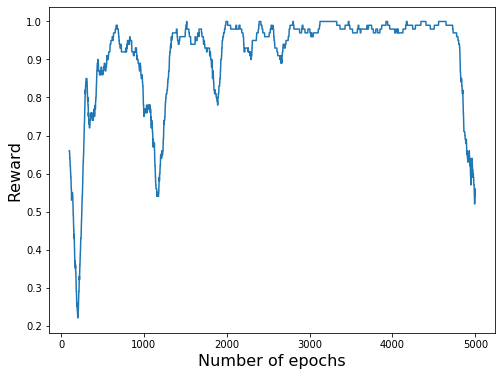

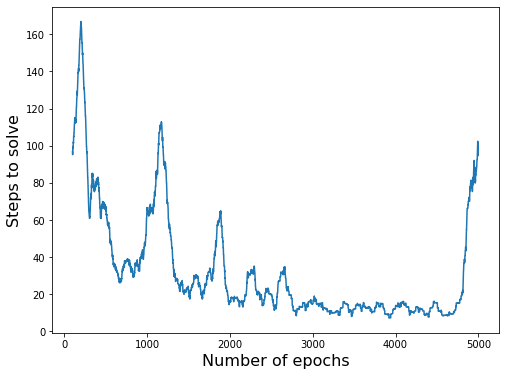

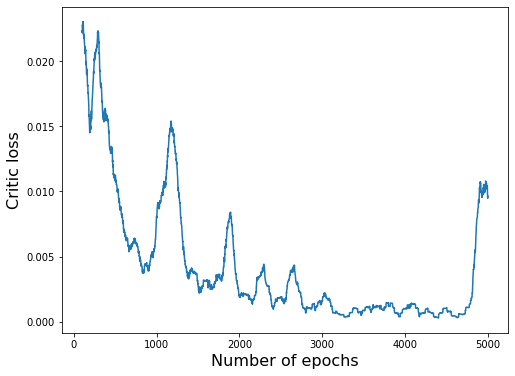

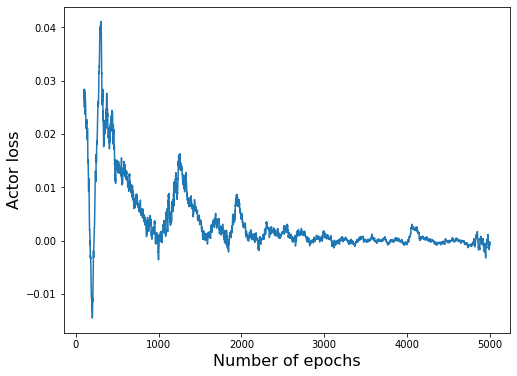

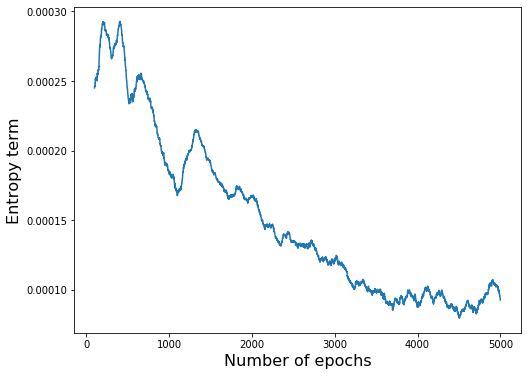

In [26]:
plot.plot_results(results, moving_average=True)

# Gated Relational Agent

In [3]:
# Variable parameters
X = 5
Y = 5
initial = [0,0]
goal = [4,4]
MAX_STEPS = 100

game_params = dict(x=X, y=Y, initial=initial, goal=goal, max_steps=MAX_STEPS, 
                   greyscale_state=True, return_ohe=True)

In [4]:
relational_HPs = torch.load("Results/Sandbox/Supervised/best_HP_S_chosen-residual_UMUT")
relational_HPs

{'n_kernels': 36,
 'n_features': 256,
 'n_heads': 1,
 'n_attn_modules': 2,
 'feature_hidden_dim': 16,
 'feature_n_residuals': 1}

In [20]:
HPs = dict(lr=1e-4, gamma=0.99, TD=True, twin=True, tau=0.3, n_steps=5, H=1e-3, radam=False, use_target=False, **relational_HPs)

if colab or torch.cuda.is_available:
    HPs['device'] = 'cuda'
else:
    HPs['device'] = 'cpu'
    
print("Using device "+HPs['device'])

# Relational Agent
agent = GatedActorCritic.GatedBoxWorldA2C(action_space = 4, **HPs)

Using device cuda


In [21]:
# see if everything works before starting the real training cycle
env = test_env.Sandbox(**game_params)
rewards, log_probs, distributions, states, done, bootstrap = train.play_episode(agent, env, max_steps=MAX_STEPS)

In [22]:
print("rewards: ", rewards.shape)
print("log_probs: ", len(log_probs))
print("distributions: ", len(distributions))
print("states: ", states.shape)
print("done: ", done.shape)
print("bootstrap: ", bootstrap.shape)

rewards:  (3,)
log_probs:  3
distributions:  3
states:  (4, 3, 7, 7)
done:  (3,)
bootstrap:  (3,)


In [23]:
agent.update(rewards, log_probs, distributions, states, done, bootstrap)

(1.3856641054153442, None, None)

## Training cycle

In [24]:
%%time
results = train.train_sandbox(agent, game_params, n_episodes = 10000,
                              max_steps=MAX_STEPS, return_agent=True, random_init=True)

Episode 10 - reward: 0.70 - steps to solve: 43.50
Episode 20 - reward: 0.70 - steps to solve: 50.60
Episode 30 - reward: 0.60 - steps to solve: 56.30
Episode 40 - reward: 0.60 - steps to solve: 76.90
Episode 50 - reward: 0.30 - steps to solve: 82.00
Episode 60 - reward: 1.00 - steps to solve: 35.80
Episode 70 - reward: 0.90 - steps to solve: 29.10
Episode 80 - reward: 0.80 - steps to solve: 39.00
Episode 90 - reward: 0.70 - steps to solve: 53.70
Episode 100 - reward: 0.80 - steps to solve: 43.40
Episode 110 - reward: 0.70 - steps to solve: 53.30
Episode 120 - reward: 0.80 - steps to solve: 45.30
Episode 130 - reward: 0.80 - steps to solve: 42.20
Episode 140 - reward: 0.70 - steps to solve: 50.00
Episode 150 - reward: 0.90 - steps to solve: 45.50
Episode 160 - reward: 0.80 - steps to solve: 33.70
Episode 170 - reward: 0.70 - steps to solve: 51.80
Episode 180 - reward: 0.90 - steps to solve: 27.80
Episode 190 - reward: 0.90 - steps to solve: 42.90
Episode 200 - reward: 1.00 - steps to so

Episode 1610 - reward: 0.50 - steps to solve: 55.40
Episode 1620 - reward: 0.50 - steps to solve: 67.10
Episode 1630 - reward: 0.60 - steps to solve: 56.50
Episode 1640 - reward: 0.40 - steps to solve: 73.90
Episode 1650 - reward: 0.50 - steps to solve: 65.50
Episode 1660 - reward: 0.40 - steps to solve: 64.40
Episode 1670 - reward: 0.50 - steps to solve: 65.80
Episode 1680 - reward: 0.50 - steps to solve: 59.00
Episode 1690 - reward: 0.30 - steps to solve: 72.30
Episode 1700 - reward: 0.70 - steps to solve: 50.90
Episode 1710 - reward: 0.70 - steps to solve: 46.30
Episode 1720 - reward: 0.70 - steps to solve: 52.10
Episode 1730 - reward: 0.70 - steps to solve: 44.10
Episode 1740 - reward: 0.60 - steps to solve: 47.00
Episode 1750 - reward: 0.60 - steps to solve: 55.10
Episode 1760 - reward: 0.70 - steps to solve: 57.80
Episode 1770 - reward: 0.90 - steps to solve: 36.80
Episode 1780 - reward: 0.60 - steps to solve: 47.80
Episode 1790 - reward: 0.40 - steps to solve: 68.60
Episode 1800

Episode 3190 - reward: 0.90 - steps to solve: 31.00
Episode 3200 - reward: 0.50 - steps to solve: 64.00
Episode 3210 - reward: 0.90 - steps to solve: 30.30
Episode 3220 - reward: 0.70 - steps to solve: 66.20
Episode 3230 - reward: 0.50 - steps to solve: 61.40
Episode 3240 - reward: 0.80 - steps to solve: 46.10
Episode 3250 - reward: 0.50 - steps to solve: 57.60
Episode 3260 - reward: 0.30 - steps to solve: 76.40
Episode 3270 - reward: 0.40 - steps to solve: 74.50
Episode 3280 - reward: 0.70 - steps to solve: 48.50
Episode 3290 - reward: 0.30 - steps to solve: 81.40
Episode 3300 - reward: 0.60 - steps to solve: 46.10
Episode 3310 - reward: 0.50 - steps to solve: 59.20
Episode 3320 - reward: 0.60 - steps to solve: 55.00
Episode 3330 - reward: 0.50 - steps to solve: 69.90
Episode 3340 - reward: 0.80 - steps to solve: 25.20
Episode 3350 - reward: 0.00 - steps to solve: 100.00
Episode 3360 - reward: 0.40 - steps to solve: 67.10
Episode 3370 - reward: 0.60 - steps to solve: 72.80
Episode 338

Episode 4770 - reward: 0.70 - steps to solve: 47.50
Episode 4780 - reward: 0.60 - steps to solve: 57.20
Episode 4790 - reward: 0.80 - steps to solve: 34.70
Episode 4800 - reward: 0.70 - steps to solve: 55.70
Episode 4810 - reward: 0.80 - steps to solve: 30.10
Episode 4820 - reward: 1.00 - steps to solve: 33.70
Episode 4830 - reward: 0.90 - steps to solve: 32.50
Episode 4840 - reward: 0.80 - steps to solve: 44.60
Episode 4850 - reward: 0.90 - steps to solve: 33.50
Episode 4860 - reward: 1.00 - steps to solve: 45.60
Episode 4870 - reward: 0.70 - steps to solve: 55.30
Episode 4880 - reward: 0.80 - steps to solve: 49.40
Episode 4890 - reward: 0.90 - steps to solve: 34.50
Episode 4900 - reward: 1.00 - steps to solve: 30.50
Episode 4910 - reward: 0.50 - steps to solve: 68.00
Episode 4920 - reward: 0.90 - steps to solve: 37.00
Episode 4930 - reward: 0.70 - steps to solve: 47.70
Episode 4940 - reward: 0.80 - steps to solve: 47.20
Episode 4950 - reward: 0.90 - steps to solve: 35.50
Episode 4960

Episode 6350 - reward: 0.90 - steps to solve: 36.20
Episode 6360 - reward: 0.90 - steps to solve: 32.50
Episode 6370 - reward: 0.80 - steps to solve: 47.20
Episode 6380 - reward: 1.00 - steps to solve: 30.60
Episode 6390 - reward: 0.60 - steps to solve: 69.40
Episode 6400 - reward: 1.00 - steps to solve: 18.20
Episode 6410 - reward: 0.60 - steps to solve: 63.90
Episode 6420 - reward: 0.90 - steps to solve: 29.50
Episode 6430 - reward: 0.90 - steps to solve: 32.70
Episode 6440 - reward: 0.90 - steps to solve: 51.70
Episode 6450 - reward: 0.80 - steps to solve: 42.70
Episode 6460 - reward: 0.80 - steps to solve: 45.40
Episode 6470 - reward: 0.90 - steps to solve: 48.20
Episode 6480 - reward: 0.90 - steps to solve: 37.20
Episode 6490 - reward: 0.80 - steps to solve: 37.80
Episode 6500 - reward: 1.00 - steps to solve: 38.90
Episode 6510 - reward: 0.90 - steps to solve: 47.90
Episode 6520 - reward: 0.90 - steps to solve: 46.00
Episode 6530 - reward: 0.90 - steps to solve: 38.40
Episode 6540

Episode 7930 - reward: 0.90 - steps to solve: 33.00
Episode 7940 - reward: 0.80 - steps to solve: 50.90
Episode 7950 - reward: 0.70 - steps to solve: 62.20
Episode 7960 - reward: 0.90 - steps to solve: 42.10
Episode 7970 - reward: 0.80 - steps to solve: 48.70
Episode 7980 - reward: 1.00 - steps to solve: 26.10
Episode 7990 - reward: 1.00 - steps to solve: 25.40
Episode 8000 - reward: 0.90 - steps to solve: 38.40
Episode 8010 - reward: 0.90 - steps to solve: 40.80
Episode 8020 - reward: 0.70 - steps to solve: 69.20
Episode 8030 - reward: 1.00 - steps to solve: 47.10
Episode 8040 - reward: 0.80 - steps to solve: 42.40
Episode 8050 - reward: 0.70 - steps to solve: 49.30
Episode 8060 - reward: 0.70 - steps to solve: 58.50
Episode 8070 - reward: 0.90 - steps to solve: 41.50
Episode 8080 - reward: 0.90 - steps to solve: 52.10
Episode 8090 - reward: 0.60 - steps to solve: 67.70
Episode 8100 - reward: 0.90 - steps to solve: 32.50
Episode 8110 - reward: 0.60 - steps to solve: 71.10
Episode 8120

Episode 9510 - reward: 0.90 - steps to solve: 47.70
Episode 9520 - reward: 0.80 - steps to solve: 42.90
Episode 9530 - reward: 0.90 - steps to solve: 49.10
Episode 9540 - reward: 0.90 - steps to solve: 28.80
Episode 9550 - reward: 0.80 - steps to solve: 45.60
Episode 9560 - reward: 0.80 - steps to solve: 42.80
Episode 9570 - reward: 1.00 - steps to solve: 31.10
Episode 9580 - reward: 0.90 - steps to solve: 25.70
Episode 9590 - reward: 0.80 - steps to solve: 59.70
Episode 9600 - reward: 0.90 - steps to solve: 37.00
Episode 9610 - reward: 0.80 - steps to solve: 35.90
Episode 9620 - reward: 0.50 - steps to solve: 66.20
Episode 9630 - reward: 1.00 - steps to solve: 39.60
Episode 9640 - reward: 1.00 - steps to solve: 28.80
Episode 9650 - reward: 0.80 - steps to solve: 47.10
Episode 9660 - reward: 1.00 - steps to solve: 32.60
Episode 9670 - reward: 0.60 - steps to solve: 72.50
Episode 9680 - reward: 0.80 - steps to solve: 45.60
Episode 9690 - reward: 0.80 - steps to solve: 48.70
Episode 9700

In [38]:
score, asymptotic_score, asymptotic_std, trained_agent, time_profile, losses, steps_to_solve = results

In [26]:
save = True
keywords = ['relational','gated','5by5', 'best-HPs','use-trg-false','update-every-5', str(len(score))+"-episodes","100-steps"] # example

if colab and save:
    %cd ~
    parent_dir = "/content/gdrive/My Drive/Colab Notebooks/"
    save_dir  = "RelationalTrained/"
    %cd "{parent_dir}"
    !mkdir "{save_dir}"
    ID = utils.save_session(save_dir, keywords, game_params, HPs, score, steps_to_solve, losses)
    torch.save(trained_agent, save_dir+"agent_"+ID)
elif save:
    save_dir = 'Results/Sandbox/'
    ID = utils.save_session(save_dir, keywords, game_params, HPs, score, steps_to_solve, losses)
    torch.save(trained_agent, save_dir+"agent_"+ID)
else:
    print("Nothing saved")
    pass

Save at Results/Sandbox/S_relational_gated_5by5_best-HPs_use-trg-false_update-every-5_10000-episodes_100-steps_RKCA


/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GatedBoxWorldActor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GatedBoxWorldNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__nam

Average time for playing one episode: 0.15 s
Average time for updating the agent: 0.08 s
Asymptotic score: 0.836 +/- 0.370


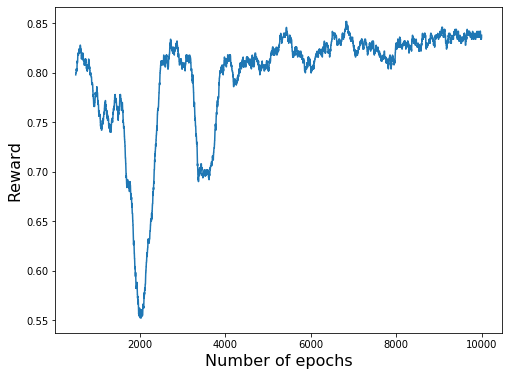

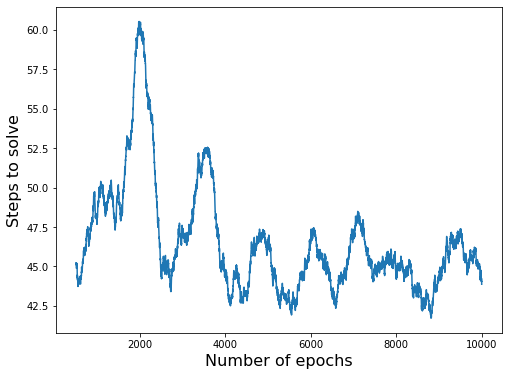

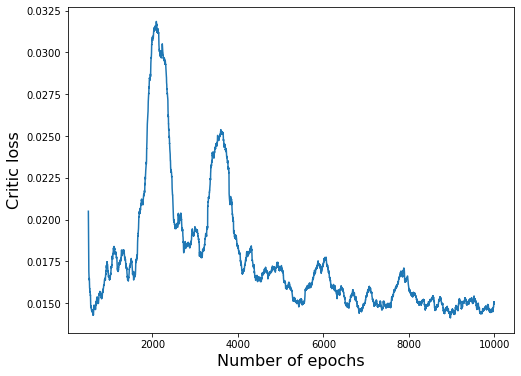

TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

<Figure size 576x432 with 0 Axes>

In [28]:
plot.plot_results(results, moving_average=True, average_window=500)

# Coordinate State Representation

Simplest representation to learn, already providing high-level features.

state = (x_agent, y_agent, x_goal, y_goal, near_borders)

In [5]:
# Variable parameters
X = 10
Y = 10
initial = [0,0]
goal = [6,7]

# All game parameters
game_params = dict(x=X, y=Y, initial=initial, goal=goal, max_steps=100, 
                   greyscale_state=False, return_coord=True, R0=0)

In [6]:
#HPs = dict(observation_space = 5, lr=5e-4, gamma=0.9, TD=True, 
#                 twin=True, tau=0.3, n_steps=5, H=1e-3, critic_lr=1e-3, radam=False, hiddens=[64,32,16])

HPs = dict(observation_space = 5, lr=5e-4, gamma=0.5, TD=True, 
                 twin=True, tau=0.3, n_steps=40, H=1e-3, radam=False, hiddens=[64,32,16])

if colab or torch.cuda.is_available:
    HPs['device'] = 'cuda'
else:
    HPs['device'] = 'cpu'
    
print("Using device "+HPs['device'])
    
# Relational Agent
agent = CoordActorCritic.CoordA2C(action_space = 4, **HPs)

In [7]:
# see if everything works before starting the real training cycle
env = test_env.Sandbox(**game_params)
rewards, log_probs, distributions, states, done, bootstrap = train.play_episode(agent, env, max_steps=50)

In [8]:
print("rewards: ", rewards.shape)
print("log_probs: ", len(log_probs))
print("distributions: ", len(distributions))
print("states: ", states.shape)
print("done: ", done.shape)
print("bootstrap: ", bootstrap.shape)

rewards:  (100,)
log_probs:  100
distributions:  100
states:  (101, 5)
done:  (100,)
bootstrap:  (100,)


In [9]:
print("rewards: \n", rewards)
print("log_probs: \n", log_probs)
print("distributions: \n", distributions)
print("states: \n", states)
print("done: \n", done)
print("bootstrap: \n", bootstrap)

rewards: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
log_probs: 
 [tensor(-1.4077, grad_fn=<SelectBackward>), tensor(-1.3915, grad_fn=<SelectBackward>), tensor(-1.3936, grad_fn=<SelectBackward>), tensor(-1.4077, grad_fn=<SelectBackward>), tensor(-1.3366, grad_fn=<SelectBackward>), tensor(-1.3366, grad_fn=<SelectBackward>), tensor(-1.4115, grad_fn=<SelectBackward>), tensor(-1.3987, grad_fn=<SelectBackward>), tensor(-1.3731, grad_fn=<SelectBackward>), tensor(-1.4371, grad_fn=<SelectBackward>), tensor(-1.3989, grad_fn=<SelectBackward>), tensor(-1.3985, grad_fn=<SelectBackward>), tensor(-1.3737, grad_fn=<SelectBackward>), tensor(-1.3985, grad_fn=<SelectBackward>), tensor(-1.4376, grad_fn=<SelectBackward>), tensor(-1.3378, grad_fn=<SelectBackward>), tensor(-1.4376, grad_fn=<SelectBackward>), tensor(-1.3378, grad_fn=<SelectBackward>

In [10]:
agent.update(rewards, log_probs, distributions, states, done, bootstrap)

(0.02651229314506054, -0.02346915751695633, -0.00034642170066945255)

# Training cycle

Reward: $R_0$ for each step except the one that ends the episode going to the goal. No penalty agains walls.

Now one should use a random agent and an optimal one to see what is the window of rewards better than random and less or equal to the best.

In [11]:
reload(train)

<module 'Utils.train_agent_sandbox' from '/home/nicola/Nicola_unipd/MasterThesis/RelationalDeepRL/Utils/train_agent_sandbox.py'>

In [12]:
#HPs = dict(observation_space = 5, lr=5e-4, gamma=0.9, TD=True, 
#                 twin=True, tau=0.3, n_steps=5, H=1e-3, critic_lr=1e-3, radam=True, hiddens=[64,32,16])
radam_HPs = dict(observation_space = 5, lr=5e-4, gamma=0.9, TD=True, 
                 twin=True, tau=0.3, n_steps=5, H=1e-3, radam=True, hiddens=[64,32,16])

if colab or torch.cuda.is_available:
    HPs['device'] = 'cuda'
else:
    HPs['device'] = 'cpu'
    
print("Using device "+HPs['device'])
    
# Relational Agent
radam_agent = CoordActorCritic.CoordA2C(action_space = 4, **radam_HPs)

In [15]:
MAX_STEPS = 100
game_params = dict(x=X, y=Y, initial=[0,0], goal=[9,9], max_steps=MAX_STEPS, 
                   greyscale_state=False, return_coord=True, R0=0)

In [0]:
%%time
radam_results = train.train_sandbox(radam_agent, game_params, n_episodes = 5000,
                              max_steps=MAX_STEPS, return_agent=True, random_init=True)

Episode 10 - reward: 0.40 - steps to solve: 79.80
Episode 20 - reward: 0.50 - steps to solve: 71.00
Episode 30 - reward: 0.50 - steps to solve: 65.70
Episode 40 - reward: 0.30 - steps to solve: 79.90
Episode 50 - reward: 0.50 - steps to solve: 68.20
Episode 60 - reward: 0.30 - steps to solve: 88.00
Episode 70 - reward: 0.30 - steps to solve: 80.70
Episode 80 - reward: 0.50 - steps to solve: 74.40
Episode 90 - reward: 0.40 - steps to solve: 72.60
Episode 100 - reward: 0.40 - steps to solve: 81.60
Episode 110 - reward: 0.50 - steps to solve: 67.20
Episode 120 - reward: 0.30 - steps to solve: 88.50
Episode 130 - reward: 0.10 - steps to solve: 91.20
Episode 140 - reward: 0.30 - steps to solve: 83.70
Episode 150 - reward: 0.30 - steps to solve: 91.20
Episode 160 - reward: 0.40 - steps to solve: 85.90
Episode 170 - reward: 0.40 - steps to solve: 73.60
Episode 180 - reward: 0.30 - steps to solve: 87.80
Episode 190 - reward: 0.50 - steps to solve: 75.20
Episode 200 - reward: 0.70 - steps to so

Episode 1610 - reward: 0.40 - steps to solve: 78.30
Episode 1620 - reward: 0.40 - steps to solve: 66.90
Episode 1630 - reward: 0.60 - steps to solve: 54.80
Episode 1640 - reward: 0.30 - steps to solve: 79.70
Episode 1650 - reward: 0.20 - steps to solve: 92.20
Episode 1660 - reward: 0.80 - steps to solve: 54.60
Episode 1670 - reward: 0.50 - steps to solve: 73.00
Episode 1680 - reward: 0.50 - steps to solve: 67.10
Episode 1690 - reward: 0.30 - steps to solve: 84.00
Episode 1700 - reward: 0.10 - steps to solve: 92.00
Episode 1710 - reward: 0.70 - steps to solve: 55.80
Episode 1720 - reward: 0.20 - steps to solve: 95.80
Episode 1730 - reward: 0.30 - steps to solve: 83.70
Episode 1740 - reward: 0.40 - steps to solve: 86.20
Episode 1750 - reward: 0.30 - steps to solve: 93.20
Episode 1760 - reward: 0.10 - steps to solve: 99.70
Episode 1770 - reward: 0.20 - steps to solve: 97.10
Episode 1780 - reward: 0.40 - steps to solve: 78.00
Episode 1790 - reward: 0.30 - steps to solve: 74.90
Episode 1800

Episode 3190 - reward: 0.50 - steps to solve: 80.50
Episode 3200 - reward: 0.80 - steps to solve: 43.50
Episode 3210 - reward: 0.60 - steps to solve: 54.90
Episode 3220 - reward: 0.60 - steps to solve: 55.00
Episode 3230 - reward: 0.30 - steps to solve: 78.90
Episode 3240 - reward: 0.30 - steps to solve: 81.60
Episode 3250 - reward: 0.60 - steps to solve: 66.70
Episode 3260 - reward: 0.90 - steps to solve: 36.90
Episode 3270 - reward: 0.70 - steps to solve: 60.20
Episode 3280 - reward: 0.60 - steps to solve: 50.90
Episode 3290 - reward: 1.00 - steps to solve: 28.70
Episode 3300 - reward: 0.60 - steps to solve: 59.20
Episode 3310 - reward: 0.70 - steps to solve: 68.00
Episode 3320 - reward: 0.20 - steps to solve: 86.80
Episode 3330 - reward: 0.60 - steps to solve: 67.00
Episode 3340 - reward: 0.80 - steps to solve: 55.20
Episode 3350 - reward: 0.50 - steps to solve: 65.80
Episode 3360 - reward: 0.40 - steps to solve: 75.50
Episode 3370 - reward: 0.50 - steps to solve: 58.00
Episode 3380

Episode 4770 - reward: 1.00 - steps to solve: 20.00
Episode 4780 - reward: 1.00 - steps to solve: 9.80
Episode 4790 - reward: 1.00 - steps to solve: 19.70
Episode 4800 - reward: 1.00 - steps to solve: 17.00
Episode 4810 - reward: 0.90 - steps to solve: 19.60
Episode 4820 - reward: 1.00 - steps to solve: 15.90
Episode 4830 - reward: 1.00 - steps to solve: 11.90
Episode 4840 - reward: 1.00 - steps to solve: 20.00
Episode 4850 - reward: 1.00 - steps to solve: 13.10
Episode 4860 - reward: 1.00 - steps to solve: 15.40
Episode 4870 - reward: 1.00 - steps to solve: 18.20
Episode 4880 - reward: 1.00 - steps to solve: 15.10
Episode 4890 - reward: 1.00 - steps to solve: 10.50
Episode 4900 - reward: 1.00 - steps to solve: 12.50
Episode 4910 - reward: 1.00 - steps to solve: 14.50
Episode 4920 - reward: 1.00 - steps to solve: 13.00
Episode 4930 - reward: 1.00 - steps to solve: 12.20
Episode 4940 - reward: 1.00 - steps to solve: 12.50
Episode 4950 - reward: 1.00 - steps to solve: 16.80
Episode 4960 

In [0]:
score, asymptotic_score, asymptotic_std, trained_agent, time_profile, losses, steps_to_solve = radam_results

In [0]:
save = True
keywords = ['radam', 'coord','10by10', 'sandbox',str(len(score))+"-episodes","100-steps"] # example

if colab and save:
    %cd ~
    parent_dir = "/content/gdrive/My Drive/Colab Notebooks/"
    save_dir  = "RelationalTrained/"
    %cd "{parent_dir}"
    !mkdir "{save_dir}"
    ID = utils.save_session(save_dir, keywords, game_params, radam_HPs, score, steps_to_solve, losses)
    torch.save(trained_agent, save_dir+"agent_"+ID)
elif save:
    save_dir = 'Results/Sandbox/'
    ID = utils.save_session(save_dir, keywords, game_params, radam_HPs, score, steps_to_solve, losses)
    torch.save(trained_agent, save_dir+"agent_"+ID)
else:
    print("Nothing saved")
    pass

Save at Results/Sandbox/S_radam_coord_10by10_sandbox_5000-episodes_100-steps_TNMC


Average time for playing one episode: 0.04 s
Average time for updating the agent: 0.04 s
Asymptotic score: 0.960 +/- 0.195


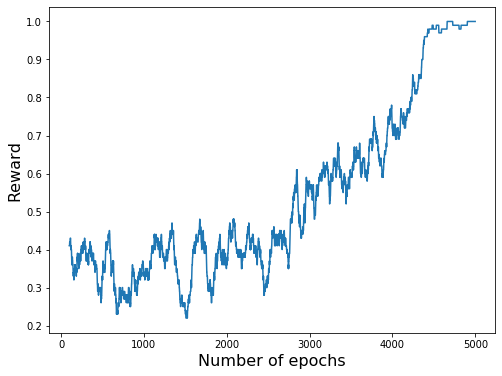

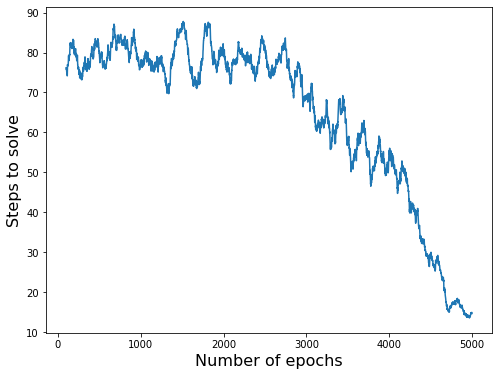

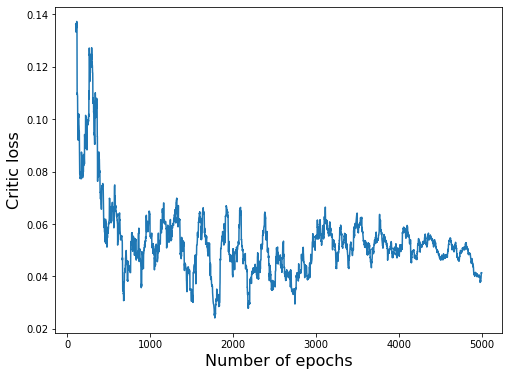

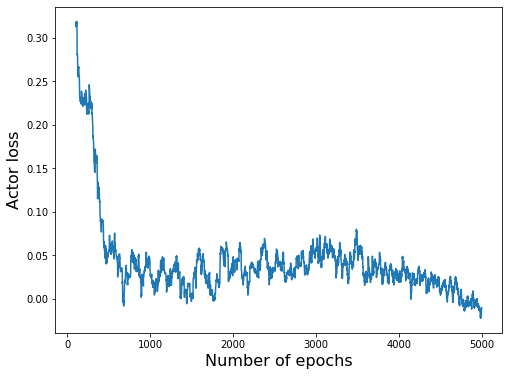

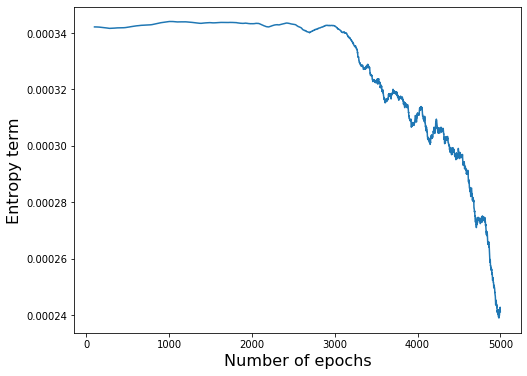

In [0]:
plot.plot_results(radam_results, moving_average=True)

In [81]:
#HPs = dict(observation_space = 5, lr=5e-4, gamma=0.9, TD=True, 
#                 twin=True, tau=0.3, n_steps=5, H=1e-3, critic_lr=1e-3, radam=False, hiddens=[64,32,16])

HPs = dict(observation_space = 5, lr=5e-4, gamma=0.99, TD=True, critic_lr=1e-3,
                 twin=True, tau=0.3, n_steps=20, H=1e-3, radam=False, hiddens=[64,32,16])

if colab or torch.cuda.is_available:
    HPs['device'] = 'cuda'
else:
    HPs['device'] = 'cpu'
    
print("Using device "+HPs['device'])
    
# Agent
agent = CoordActorCritic.CoordA2C(action_space = 4, **HPs)

In [82]:
%%time
results = train.train_sandbox(agent, game_params, n_episodes = 5000,
                              max_steps=MAX_STEPS, return_agent=True, random_init=True)

Episode 10 - reward: 0.40 - steps to solve: 75.40
Episode 20 - reward: 0.40 - steps to solve: 70.10
Episode 30 - reward: 0.20 - steps to solve: 95.80
Episode 40 - reward: 0.50 - steps to solve: 80.70
Episode 50 - reward: 0.20 - steps to solve: 85.20
Episode 60 - reward: 0.60 - steps to solve: 66.50
Episode 70 - reward: 0.50 - steps to solve: 72.40
Episode 80 - reward: 0.30 - steps to solve: 82.50
Episode 90 - reward: 0.40 - steps to solve: 77.30
Episode 100 - reward: 0.40 - steps to solve: 79.60
Episode 110 - reward: 0.40 - steps to solve: 77.20
Episode 120 - reward: 0.50 - steps to solve: 81.50
Episode 130 - reward: 0.20 - steps to solve: 87.70
Episode 140 - reward: 0.20 - steps to solve: 86.70
Episode 150 - reward: 0.30 - steps to solve: 85.00
Episode 160 - reward: 0.50 - steps to solve: 64.10
Episode 170 - reward: 0.30 - steps to solve: 80.10
Episode 180 - reward: 0.30 - steps to solve: 78.00
Episode 190 - reward: 0.50 - steps to solve: 78.90
Episode 200 - reward: 0.50 - steps to so

Episode 1610 - reward: 0.90 - steps to solve: 35.50
Episode 1620 - reward: 0.90 - steps to solve: 39.60
Episode 1630 - reward: 0.90 - steps to solve: 41.10
Episode 1640 - reward: 0.90 - steps to solve: 48.80
Episode 1650 - reward: 0.70 - steps to solve: 67.60
Episode 1660 - reward: 0.90 - steps to solve: 37.40
Episode 1670 - reward: 1.00 - steps to solve: 36.20
Episode 1680 - reward: 0.90 - steps to solve: 59.60
Episode 1690 - reward: 0.80 - steps to solve: 39.70
Episode 1700 - reward: 0.90 - steps to solve: 39.10
Episode 1710 - reward: 1.00 - steps to solve: 30.30
Episode 1720 - reward: 0.50 - steps to solve: 73.30
Episode 1730 - reward: 0.60 - steps to solve: 53.60
Episode 1740 - reward: 0.80 - steps to solve: 53.70
Episode 1750 - reward: 0.80 - steps to solve: 50.50
Episode 1760 - reward: 0.60 - steps to solve: 63.60
Episode 1770 - reward: 0.90 - steps to solve: 56.50
Episode 1780 - reward: 0.60 - steps to solve: 69.00
Episode 1790 - reward: 0.90 - steps to solve: 47.00
Episode 1800

Episode 3190 - reward: 1.00 - steps to solve: 18.10
Episode 3200 - reward: 1.00 - steps to solve: 17.90
Episode 3210 - reward: 1.00 - steps to solve: 17.90
Episode 3220 - reward: 1.00 - steps to solve: 18.10
Episode 3230 - reward: 1.00 - steps to solve: 16.10
Episode 3240 - reward: 1.00 - steps to solve: 13.50
Episode 3250 - reward: 1.00 - steps to solve: 9.80
Episode 3260 - reward: 1.00 - steps to solve: 15.20
Episode 3270 - reward: 1.00 - steps to solve: 9.70
Episode 3280 - reward: 1.00 - steps to solve: 13.70
Episode 3290 - reward: 1.00 - steps to solve: 12.50
Episode 3300 - reward: 1.00 - steps to solve: 11.50
Episode 3310 - reward: 1.00 - steps to solve: 13.30
Episode 3320 - reward: 1.00 - steps to solve: 10.80
Episode 3330 - reward: 1.00 - steps to solve: 15.90
Episode 3340 - reward: 1.00 - steps to solve: 16.30
Episode 3350 - reward: 1.00 - steps to solve: 12.10
Episode 3360 - reward: 1.00 - steps to solve: 10.60
Episode 3370 - reward: 1.00 - steps to solve: 13.10
Episode 3380 -

Episode 4780 - reward: 1.00 - steps to solve: 9.90
Episode 4790 - reward: 1.00 - steps to solve: 10.40
Episode 4800 - reward: 1.00 - steps to solve: 8.40
Episode 4810 - reward: 1.00 - steps to solve: 9.00
Episode 4820 - reward: 1.00 - steps to solve: 9.50
Episode 4830 - reward: 1.00 - steps to solve: 9.30
Episode 4840 - reward: 1.00 - steps to solve: 9.30
Episode 4850 - reward: 1.00 - steps to solve: 10.40
Episode 4860 - reward: 1.00 - steps to solve: 7.60
Episode 4870 - reward: 1.00 - steps to solve: 12.70
Episode 4880 - reward: 1.00 - steps to solve: 11.50
Episode 4890 - reward: 1.00 - steps to solve: 10.40
Episode 4900 - reward: 1.00 - steps to solve: 6.10
Episode 4910 - reward: 1.00 - steps to solve: 6.80
Episode 4920 - reward: 1.00 - steps to solve: 6.70
Episode 4930 - reward: 1.00 - steps to solve: 6.60
Episode 4940 - reward: 1.00 - steps to solve: 10.30
Episode 4950 - reward: 1.00 - steps to solve: 6.20
Episode 4960 - reward: 1.00 - steps to solve: 7.80
Episode 4970 - reward: 1.

In [83]:
score, asymptotic_score, asymptotic_std, trained_agent, time_profile, losses, steps_to_solve = results

In [84]:
save = True
keywords = ['adam', 'coord','10by10', 'critic-lr-1e-3', 'TD(20)','sandbox',str(len(score))+"-episodes","100-steps"] # example

if colab and save:
    %cd ~
    parent_dir = "/content/gdrive/My Drive/Colab Notebooks/"
    save_dir  = "RelationalTrained/"
    %cd "{parent_dir}"
    !mkdir "{save_dir}"
    ID = utils.save_session(save_dir, keywords, game_params, HPs, score, steps_to_solve, losses)
    torch.save(trained_agent, save_dir+"agent_"+ID)
elif save:
    save_dir = 'Results/Sandbox/'
    ID = utils.save_session(save_dir, keywords, game_params, HPs, score, steps_to_solve, losses)
    torch.save(trained_agent, save_dir+"agent_"+ID)
else:
    print("Nothing saved")
    pass

Save at Results/Sandbox/S_adam_coord_10by10_critic-lr-1e-3_TD(20)_sandbox_5000-episodes_100-steps_SGIF


Average time for playing one episode: 0.02 s
Average time for updating the agent: 0.03 s
Asymptotic score: 1.000 +/- 0.000


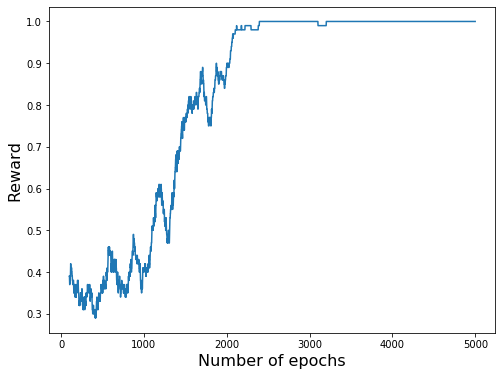

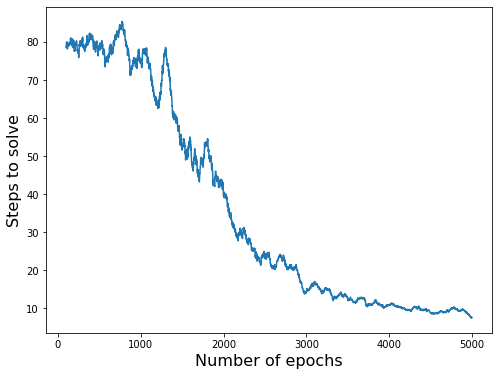

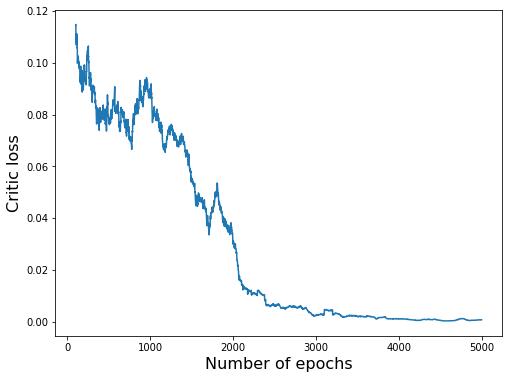

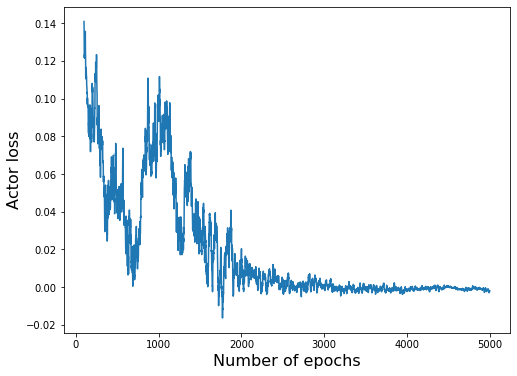

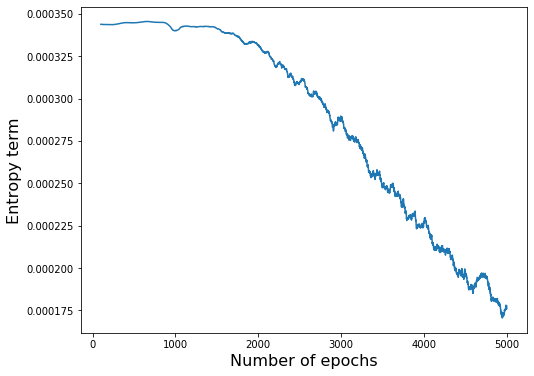

In [85]:
plot.plot_results(results, moving_average=True)

**How to read and interpret:** Entropy is higher for policies that are highly stochastic and zero for those that are deterministic. The spikes toward smaller entropies are probably due to strong feedbacks (either positive or negative ones). If we have |A| possible actions, the maximum value of the entropy is:
$$S = \sum_{a=1}^4 - \frac{1}{|A|}log\left( \frac{1}{|A|} \right) = - log\left( \frac{1}{|A|} \right) = +log(|A|) \approx 1.4 $$
Given that the actor updates have order of the hundred, we should use a coupling constant much higher that the one currently used $(10^{-2})$. The other problem is that scaling the reward would leave the entropy unchanged, thus if the actor loss changes of many orders of magnitude during training, we must be aware that entropy regularization might become a real problem.

## RAdam vs Adam

In [0]:
reload(plot)

<module 'Utils.plot' from '/home/nicola/Nicola_unipd/MasterThesis/RelationalDeepRL/Utils/plot.py'>

Average time (1) for playing one episode: 0.04 s
Average time (1) for updating the agent: 0.04 s
Asymptotic score (1): 0.960 +/- 0.195
Average time (2) for playing one episode: 0.02 s
Average time (2) for updating the agent: 0.03 s
Asymptotic score (2): 1.000 +/- 0.000


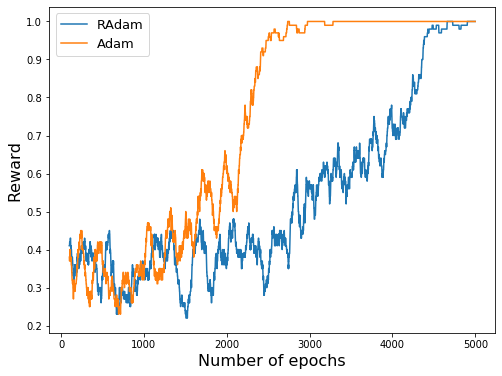

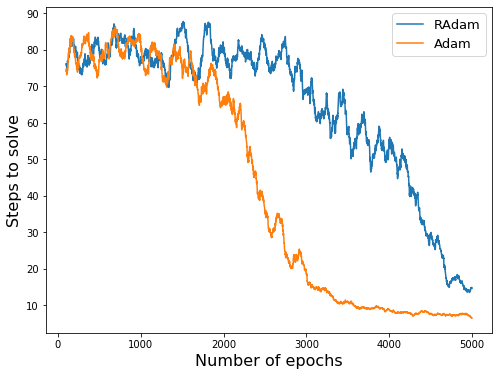

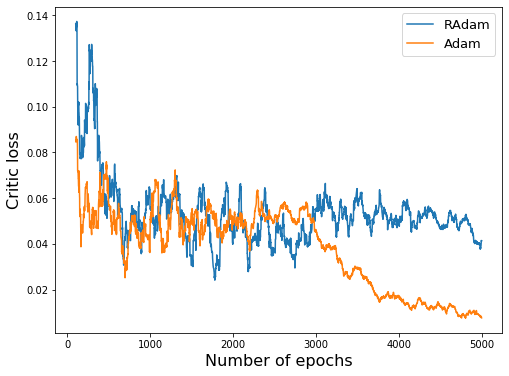

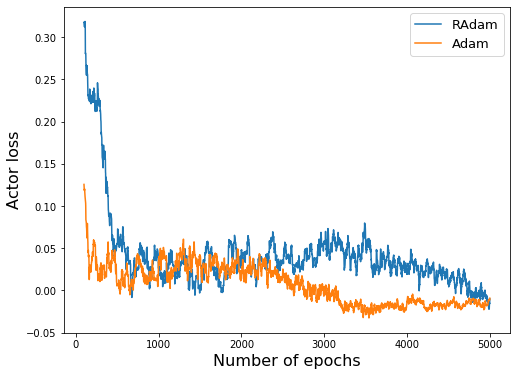

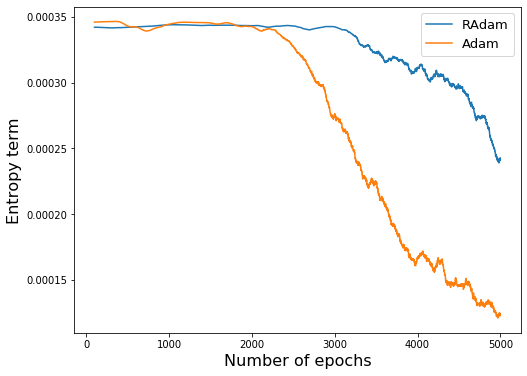

In [0]:
plot.compare_results(radam_results, results, 'RAdam', 'Adam', moving_average=True)

In this case RAdam was sligthly worse, but still competitive. Notice that the learning rates for the actor (5e-4) and the critic (1e-3) were already tuned somehow using Adam.

## Test

In [0]:
env = test_env.Sandbox(**game_params)
R = 0
test_episodes = 100
max_steps = 30
tot_steps = 0

for i in range(test_episodes):
    rewards, log_probs, distributions, states, done, bootstrap = train.play_episode(trained_agent, env, max_steps=max_steps)
    #print("Solved in %d steps"%len(rewards))
    R += rewards.sum()
    tot_steps += len(rewards)
print("Average reward: ", R/test_episodes)
print("Steps to solve: ", tot_steps/test_episodes)

Average reward:  1.0
Steps to solve:  7.52


In [0]:
reload(utils)

<IPython.core.display.Javascript object>


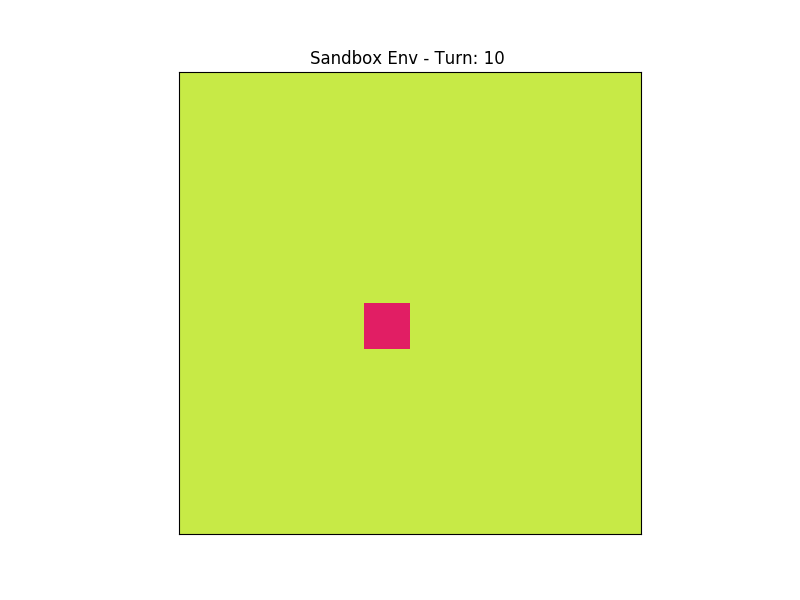

In [0]:
import matplotlib.pyplot as plt
import time
%matplotlib notebook

# Variable parameters
X = 10
Y = 10
initial = [0,9]
goal = [5,4]

# All game parameters
#game_params = dict(x=X, y=Y, initial=initial, goal=goal, max_steps=100, greyscale_state=True)
game_params = dict(x=X, y=Y, initial=initial, goal=goal, max_steps=100, 
                   greyscale_state=False, return_coord=True)

env = test_env.Sandbox(**game_params)
utils.render(trained_agent, env, save=False)
%matplotlib inline

# OneHotEncoded State Representation

Working on 5x5 (100 steps max) or 10x10 (200 step max).

STATUS:
1. 10x10 solved in 15.000 epochs with control architecture (see below)
2. 5x5 tested in Adam vs RAdam

**Results:**
- Convergence: 10000 epochs
- Asymptotic performance: NOT AVAILABLE/SHOULD BE COMPUTED IN STEPS-TO-SOLVE

**Hyper-parameters:**
- Architecture: defautl values*
- Learning rate: 5e-4 
- Discount factor: 0.9 
- Tau: 0.1 
- n-steps: 40 
- H: 1e-1 
- solver: Adam


In [3]:
# Variable parameters
X = 5
Y = 5
initial = [0,0]
goal = [4,4]
MAX_STEPS = 100

game_params = dict(x=X, y=Y, initial=initial, goal=goal, max_steps=MAX_STEPS, 
                   greyscale_state=True, return_ohe=True)

In [6]:
HPs = dict(lr=5e-4, gamma=0.9, TD=True, twin=True, tau=0.3, n_steps=5, H=1e-3,  critic_lr=1e-3)

if colab or torch.cuda.is_available:
    HPs['device'] = 'cuda'
else:
    HPs['device'] = 'cpu'
    
print("Using device "+HPs['device'])

# Relational Agent
agent = OheActorCritic.OheA2C(action_space = 4, map_size=X, **HPs)

Using device cuda


In [7]:
# see if everything works before starting the real training cycle
env = test_env.Sandbox(**game_params)
rewards, log_probs, distributions, states, done, bootstrap = train.play_episode(agent, env, max_steps=MAX_STEPS)

In [8]:
print("rewards: ", rewards.shape)
print("log_probs: ", len(log_probs))
print("distributions: ", len(distributions))
print("states: ", states.shape)
print("done: ", done.shape)
print("bootstrap: ", bootstrap.shape)

rewards:  (100,)
log_probs:  100
distributions:  100
states:  (101, 3, 7, 7)
done:  (100,)
bootstrap:  (100,)


## Training cycle

In [0]:
radam_HPs = dict(lr=5e-4, gamma=0.9, TD=True, twin=True, tau=0.3, n_steps=5, H=1e-3,  critic_lr=1e-3, radam=True)

if colab or torch.cuda.is_available:
    radam_HPs['device'] = 'cuda'
else:
    radam_HPs['device'] = 'cpu'
    
print("Using device "+radam_HPs['device'])
    
# Relational Agent
radam_agent = OheActorCritic.OheA2C(action_space = 4, map_size=X, **radam_HPs)

In [0]:
%%time
radam_results = train.train_sandbox(radam_agent, game_params, n_episodes = 5000,
                              max_steps=MAX_STEPS, return_agent=True, random_init=True)

Episode 10 - reward: 0.30 - steps to solve: 74.10
Episode 20 - reward: 0.20 - steps to solve: 87.40
Episode 30 - reward: 0.50 - steps to solve: 83.00
Episode 40 - reward: 0.70 - steps to solve: 51.80
Episode 50 - reward: 0.30 - steps to solve: 83.40
Episode 60 - reward: 0.60 - steps to solve: 55.50
Episode 70 - reward: 0.40 - steps to solve: 79.60
Episode 80 - reward: 0.30 - steps to solve: 86.70
Episode 90 - reward: 0.30 - steps to solve: 81.60
Episode 100 - reward: 0.50 - steps to solve: 67.30
Episode 110 - reward: 0.50 - steps to solve: 79.20
Episode 120 - reward: 0.70 - steps to solve: 66.40
Episode 130 - reward: 0.80 - steps to solve: 40.40
Episode 140 - reward: 0.60 - steps to solve: 56.00
Episode 150 - reward: 0.40 - steps to solve: 69.70
Episode 160 - reward: 0.70 - steps to solve: 48.80
Episode 170 - reward: 0.50 - steps to solve: 64.80
Episode 180 - reward: 0.30 - steps to solve: 84.40
Episode 190 - reward: 0.40 - steps to solve: 64.60
Episode 200 - reward: 0.30 - steps to so

In [0]:
score, asymptotic_score, asymptotic_std, trained_agent, time_profile, losses, steps_to_solve = radam_results

In [0]:
save = True
keywords = ['radam', 'ohe','5by5', 'sandbox',str(len(score))+"-episodes","100-steps"] # example

if colab and save:
    %cd ~
    parent_dir = "/content/gdrive/My Drive/Colab Notebooks/"
    save_dir  = "RelationalTrained/"
    %cd "{parent_dir}"
    !mkdir "{save_dir}"
    ID = utils.save_session(save_dir, keywords, game_params, radam_HPs, score, steps_to_solve, losses)
    torch.save(trained_agent, save_dir+"agent_"+ID)
elif save:
    save_dir = 'Results/Sandbox/'
    ID = utils.save_session(save_dir, keywords, game_params, radam_HPs, score, steps_to_solve, losses)
    torch.save(trained_agent, save_dir+"agent_"+ID)
else:
    print("Nothing saved")
    pass

/root
/content/gdrive/My Drive/Colab Notebooks
mkdir: cannot create directory ‘RelationalTrained/’: File exists
Save at RelationalTrained/S_radam_ohe_5by5_sandbox_5000-episodes_100-steps_DJHB


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type OheActor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type OheNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Convolution. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type PositionalEncoding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/li

Average time for playing one episode: 0.17 s
Average time for updating the agent: 0.26 s
Asymptotic score: 1.000 +/- 0.000


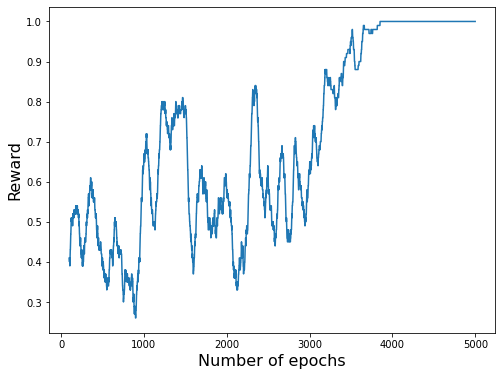

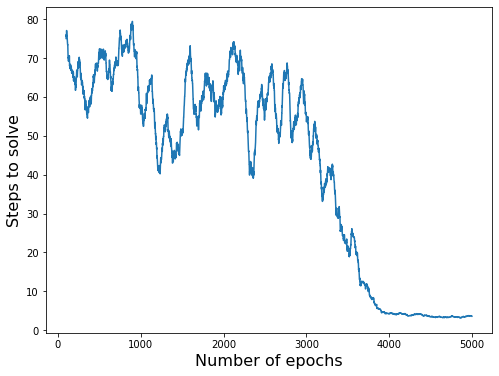

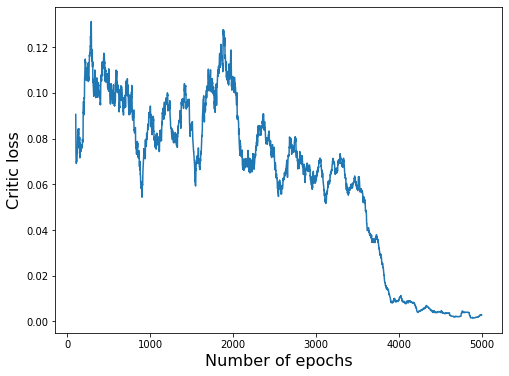

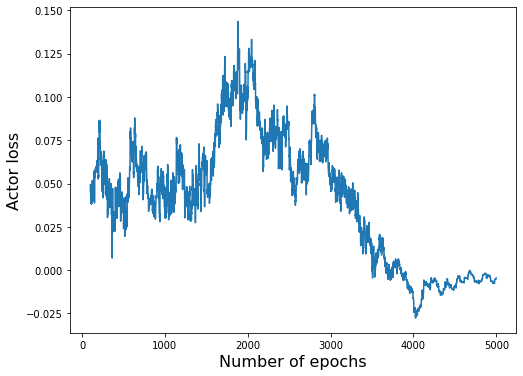

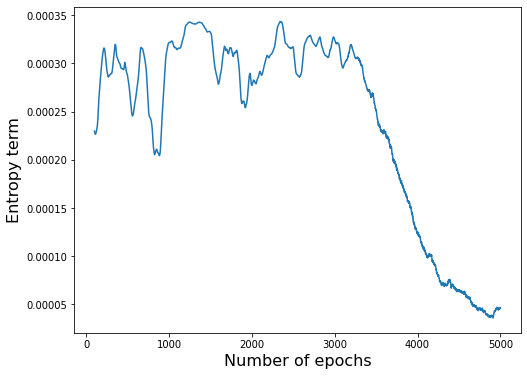

In [0]:
plot.plot_results(radam_results, moving_average=True)

In [14]:
HPs = dict(lr=1e-5, gamma=0.99, TD=True, twin=True, tau=0.3, n_steps=20, H=1e-3,  critic_lr=1e-4)

if colab or torch.cuda.is_available:
    HPs['device'] = 'cuda'
else:
    HPs['device'] = 'cpu'
    
print("Using device "+HPs['device'])
    
# Relational Agent
agent = OheActorCritic.OheA2C(action_space = 4, map_size=X, **HPs)

Using device cuda


In [15]:
%%time
results = train.train_sandbox(agent, game_params, n_episodes = 5000,
                              max_steps=MAX_STEPS, return_agent=True, random_init=True)

Episode 10 - reward: 0.40 - steps to solve: 65.30
Episode 20 - reward: 0.40 - steps to solve: 67.30
Episode 30 - reward: 0.50 - steps to solve: 73.90
Episode 40 - reward: 0.50 - steps to solve: 59.60
Episode 50 - reward: 0.30 - steps to solve: 80.60
Episode 60 - reward: 0.50 - steps to solve: 56.70
Episode 70 - reward: 0.60 - steps to solve: 43.30
Episode 80 - reward: 0.50 - steps to solve: 65.60
Episode 90 - reward: 0.40 - steps to solve: 73.80
Episode 100 - reward: 0.60 - steps to solve: 62.20
Episode 110 - reward: 0.30 - steps to solve: 74.40
Episode 120 - reward: 0.50 - steps to solve: 66.30
Episode 130 - reward: 0.30 - steps to solve: 73.40
Episode 140 - reward: 0.30 - steps to solve: 82.00
Episode 150 - reward: 0.50 - steps to solve: 54.50
Episode 160 - reward: 0.50 - steps to solve: 58.00
Episode 170 - reward: 0.60 - steps to solve: 56.40
Episode 180 - reward: 0.50 - steps to solve: 66.50
Episode 190 - reward: 0.20 - steps to solve: 82.00
Episode 200 - reward: 0.20 - steps to so

Episode 1610 - reward: 0.60 - steps to solve: 55.90
Episode 1620 - reward: 0.70 - steps to solve: 43.70
Episode 1630 - reward: 0.80 - steps to solve: 35.30
Episode 1640 - reward: 0.60 - steps to solve: 62.40
Episode 1650 - reward: 0.80 - steps to solve: 45.80
Episode 1660 - reward: 0.70 - steps to solve: 47.90
Episode 1670 - reward: 0.90 - steps to solve: 46.10
Episode 1680 - reward: 0.80 - steps to solve: 34.20
Episode 1690 - reward: 0.90 - steps to solve: 46.60
Episode 1700 - reward: 0.90 - steps to solve: 23.10
Episode 1710 - reward: 0.80 - steps to solve: 38.50
Episode 1720 - reward: 0.90 - steps to solve: 33.60
Episode 1730 - reward: 0.80 - steps to solve: 32.10
Episode 1740 - reward: 0.60 - steps to solve: 54.80
Episode 1750 - reward: 0.60 - steps to solve: 65.10
Episode 1760 - reward: 0.80 - steps to solve: 43.70
Episode 1770 - reward: 0.80 - steps to solve: 43.50
Episode 1780 - reward: 0.70 - steps to solve: 51.30
Episode 1790 - reward: 0.90 - steps to solve: 35.10
Episode 1800

Episode 3190 - reward: 0.80 - steps to solve: 56.30
Episode 3200 - reward: 1.00 - steps to solve: 24.30
Episode 3210 - reward: 0.50 - steps to solve: 65.90
Episode 3220 - reward: 0.70 - steps to solve: 60.20
Episode 3230 - reward: 1.00 - steps to solve: 32.80
Episode 3240 - reward: 0.70 - steps to solve: 68.80
Episode 3250 - reward: 1.00 - steps to solve: 36.80
Episode 3260 - reward: 1.00 - steps to solve: 27.70
Episode 3270 - reward: 1.00 - steps to solve: 31.10
Episode 3280 - reward: 0.80 - steps to solve: 44.30
Episode 3290 - reward: 1.00 - steps to solve: 34.50
Episode 3300 - reward: 0.70 - steps to solve: 50.50
Episode 3310 - reward: 0.70 - steps to solve: 63.00
Episode 3320 - reward: 1.00 - steps to solve: 43.10
Episode 3330 - reward: 0.90 - steps to solve: 39.20
Episode 3340 - reward: 0.70 - steps to solve: 55.70
Episode 3350 - reward: 0.60 - steps to solve: 61.90
Episode 3360 - reward: 0.80 - steps to solve: 49.40
Episode 3370 - reward: 0.90 - steps to solve: 30.10
Episode 3380

Episode 4770 - reward: 0.90 - steps to solve: 32.30
Episode 4780 - reward: 0.90 - steps to solve: 33.70
Episode 4790 - reward: 1.00 - steps to solve: 34.00
Episode 4800 - reward: 0.80 - steps to solve: 43.20
Episode 4810 - reward: 0.80 - steps to solve: 41.30
Episode 4820 - reward: 0.90 - steps to solve: 32.10
Episode 4830 - reward: 0.90 - steps to solve: 32.40
Episode 4840 - reward: 0.80 - steps to solve: 41.90
Episode 4850 - reward: 0.70 - steps to solve: 54.40
Episode 4860 - reward: 1.00 - steps to solve: 29.00
Episode 4870 - reward: 0.80 - steps to solve: 44.40
Episode 4880 - reward: 0.80 - steps to solve: 42.90
Episode 4890 - reward: 0.80 - steps to solve: 39.60
Episode 4900 - reward: 0.90 - steps to solve: 52.90
Episode 4910 - reward: 0.80 - steps to solve: 52.70
Episode 4920 - reward: 0.90 - steps to solve: 27.90
Episode 4930 - reward: 0.80 - steps to solve: 52.60
Episode 4940 - reward: 0.90 - steps to solve: 41.10
Episode 4950 - reward: 0.60 - steps to solve: 68.60
Episode 4960

In [16]:
score, asymptotic_score, asymptotic_std, trained_agent, time_profile, losses, steps_to_solve = results

In [17]:
save = True
keywords = ['adam', 'ohe','5by5', 'TD(20)', 'critic-lr-1e-4', 'sandbox',str(len(score))+"-episodes","100-steps"] # example

if colab and save:
    %cd ~
    parent_dir = "/content/gdrive/My Drive/Colab Notebooks/"
    save_dir  = "RelationalTrained/"
    %cd "{parent_dir}"
    !mkdir "{save_dir}"
    ID = utils.save_session(save_dir, keywords, game_params, HPs, score, steps_to_solve, losses)
    torch.save(trained_agent, save_dir+"agent_"+ID)
elif save:
    save_dir = 'Results/Sandbox/'
    ID = utils.save_session(save_dir, keywords, game_params, HPs, score, steps_to_solve, losses)
    torch.save(trained_agent, save_dir+"agent_"+ID)
else:
    print("Nothing saved")
    pass

Save at Results/Sandbox/S_adam_ohe_5by5_TD(20)_critic-lr-1e-4_sandbox_5000-episodes_100-steps_YNKO


/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type OheActor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type OheNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Convolution. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't b

Average time for playing one episode: 0.12 s
Average time for updating the agent: 0.19 s
Asymptotic score: 0.844 +/- 0.363


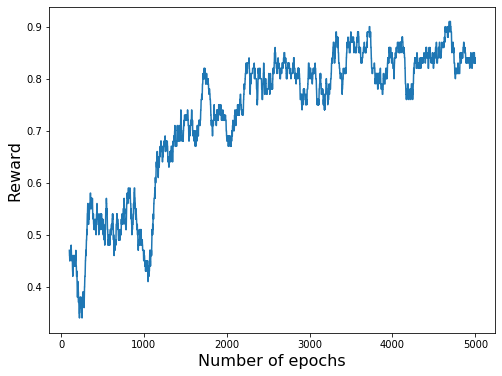

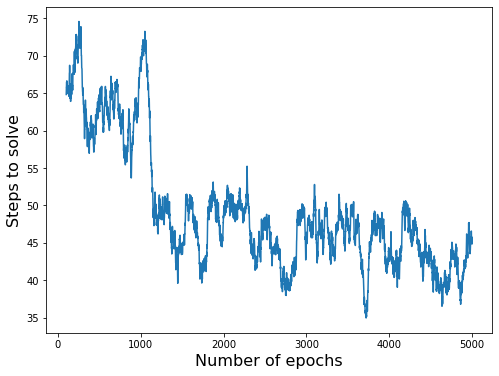

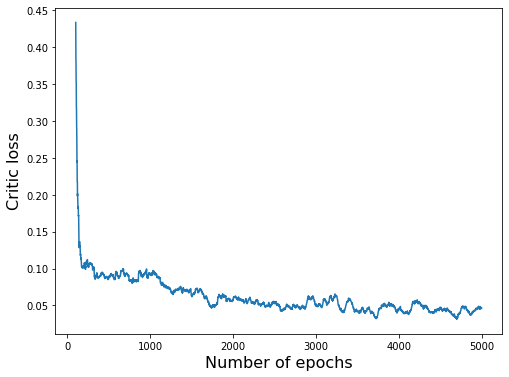

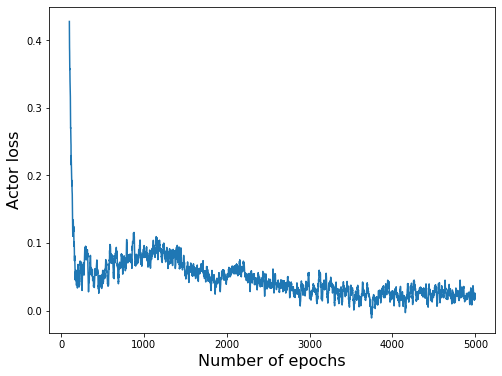

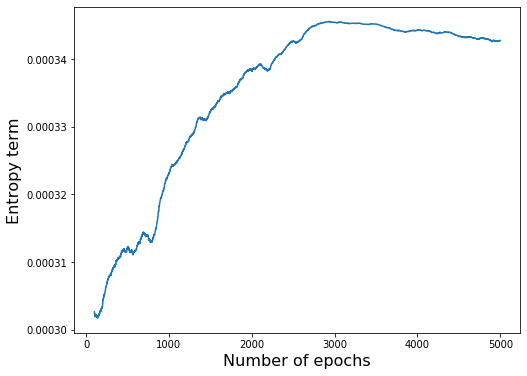

In [18]:
plot.plot_results(results, moving_average=True)

Average time (1) for playing one episode: 0.17 s
Average time (1) for updating the agent: 0.26 s
Asymptotic score (1): 1.000 +/- 0.000
Average time (2) for playing one episode: 0.20 s
Average time (2) for updating the agent: 0.28 s
Asymptotic score (2): 0.998 +/- 0.049


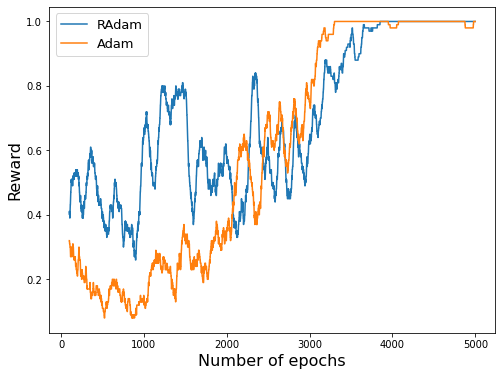

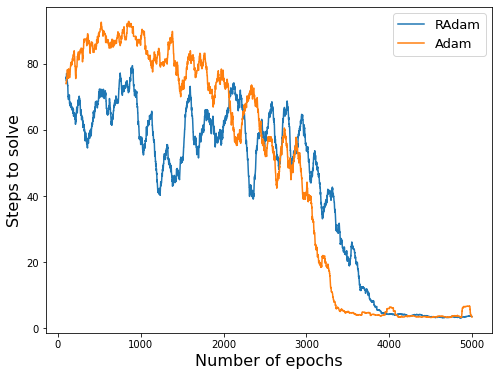

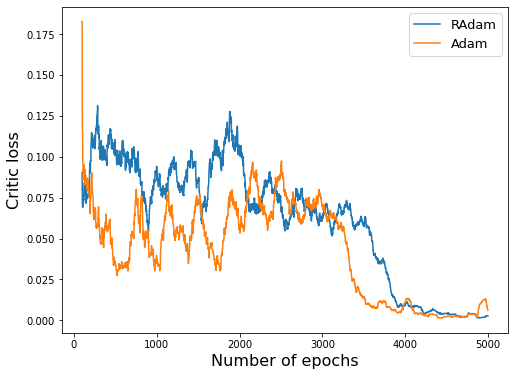

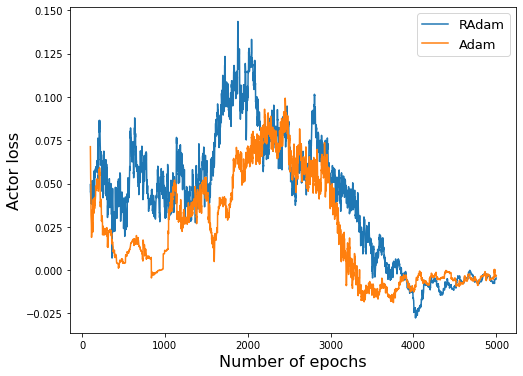

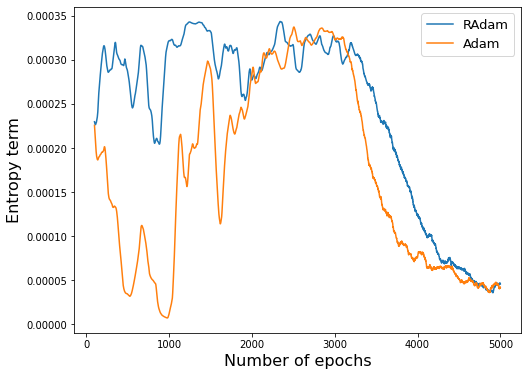

In [0]:
plot.compare_results(radam_results, results, 'RAdam', 'Adam', moving_average=True)

## Reloading partially trained agent

In [0]:
load_dir = "Results/Sandbox/"
queries = ['ohe', 'sandbox']
train_dict = utils.load_session(load_dir, queries)

game_params = train_dict['game_params']
HPs = train_dict['HPs']
score = train_dict['score']
keywords = train_dict['keywords']
ID = keywords[-1]

# Load agent 
if colab:
    trained_agent = torch.load(load_dir+"agent_"+ID)
else:
    trained_agent = torch.load(load_dir+"agent_"+ID, map_location=torch.device('cpu'))
    trained_agent.device = 'cpu'

In [0]:
%%time
results = train.train_sandbox(agent, game_params, n_episodes = 5000,
                              max_steps=MAX_STEPS, return_agent=True, random_init=True)

In [0]:
score, asymptotic_score, asymptotic_std, trained_agent, time_profile, losses, steps_to_solve = results

In [0]:
import matplotlib.pyplot as plt
import time
%matplotlib notebook

# Variable parameters

X = 10
Y = 10
initial = [0,0]
goal = [9,9]
MAX_STEPS = 100

game_params = dict(x=X, y=Y, initial=initial, goal=goal, max_steps=MAX_STEPS, 
                   greyscale_state=True, return_ohe=True)

env = test_env.Sandbox(**game_params)
utils.render(trained_agent, env, save=False)

In [0]:
save = True
keywords = ['control', '10by10',str(len(score))+"-episodes","200-steps","NQBK-pt2"] # example

if colab and save:
    %cd ~
    parent_dir = "/content/gdrive/My Drive/Colab Notebooks/"
    save_dir  = "RelationalTrained/"
    %cd "{parent_dir}"
    !mkdir "{save_dir}"
    ID = utils.save_session(save_dir, keywords, game_params, HPs, score)
    torch.save(trained_agent, save_dir+"agent_"+ID)
elif save:
    save_dir = 'Results/Sandbox/'
    ID = utils.save_session(save_dir, keywords, game_params, HPs, score)
    torch.save(trained_agent, save_dir+"agent_"+ID)
else:
    print("Nothing saved")
    pass

## Relational agent with OHE state representation

TODO:
1. Adam vs RAdam in 5x5, 100 steps, 10000 epochs, lr 5e-4 for both actor and critic, n-steps 5, tau 0.3 [ok]
2. Adam vs RAdam in 5x5, 100 steps, 10000 epochs, lr 5e-3 for both actor and critic, n-steps 5, tau 0.3
3. Adam vs RAdam in 5x5, 100 steps, 10000 epochs, lr 5e-4 for both actor and critic, n-steps 5, tau 0.3
4. Adam vs RAdam in 5x5, 100 steps, 10000 epochs, lr best of above, n-steps 5, tau 0.1
5. Adam vs RAdam in 5x5, 100 steps, 10000 epochs, lr best of above, n-steps 20, tau 0.3
6. Adam vs RAdam in 5x5, 100 steps, 10000 epochs, lr best of above, n-steps 40, tau 0.3

DONE:

In [0]:
# Variable parameters
X = 5
Y = 5
initial = [0,0]
goal = [4,4]
MAX_STEPS = 100

game_params = dict(x=X, y=Y, initial=initial, goal=goal, max_steps=MAX_STEPS, 
                   greyscale_state=True, return_ohe=True)

In [0]:
HPs = dict(lr=5e-4, gamma=0.9, TD=True, twin=True, tau=0.3, n_steps=5, H=1e-3, radam=False)

if colab:
    HPs['device'] = 'cuda'
else:
    HPs['device'] = 'cpu'

# Relational Agent
agent = ActorCritic.BoxWorldA2C(action_space = 4, **HPs)

In [0]:
# see if everything works before starting the real training cycle
env = test_env.Sandbox(**game_params)
rewards, log_probs, distributions, states, done, bootstrap = train.play_episode(agent, env, max_steps=MAX_STEPS)

In [0]:
print("rewards: ", rewards.shape)
print("log_probs: ", len(log_probs))
print("distributions: ", len(distributions))
print("states: ", states.shape)
print("done: ", done.shape)
print("bootstrap: ", bootstrap.shape)

rewards:  (100,)
log_probs:  100
distributions:  100
states:  (101, 3, 7, 7)
done:  (100,)
bootstrap:  (100,)


In [0]:
agent.update(rewards, log_probs, distributions, states, done, bootstrap)

(0.17137694358825684, 0.3021453320980072, -0.00030972572858445346)

## Training cycle

In [0]:
radam_HPs = dict(lr=5e-4, gamma=0.9, TD=True, twin=True, tau=0.3, n_steps=5, H=1e-3, radam=True)

if colab:
    radam_HPs['device'] = 'cuda'
else:
    radam_HPs['device'] = 'cpu'

# Relational Agent
radam_agent = ActorCritic.BoxWorldA2C(action_space = 4, **radam_HPs)

In [0]:
%%time
radam_results = train.train_sandbox(trained_agent, game_params, n_episodes=5000,
                              max_steps=MAX_STEPS, return_agent=True, random_init=True)

Episode 10 - reward: 0.80 - steps to solve: 39.20
Episode 20 - reward: 0.90 - steps to solve: 48.20
Episode 30 - reward: 0.70 - steps to solve: 56.60
Episode 40 - reward: 0.60 - steps to solve: 59.70
Episode 50 - reward: 0.80 - steps to solve: 46.20
Episode 60 - reward: 0.90 - steps to solve: 46.60
Episode 70 - reward: 0.90 - steps to solve: 43.70
Episode 80 - reward: 0.80 - steps to solve: 50.90
Episode 90 - reward: 0.60 - steps to solve: 54.50
Episode 100 - reward: 0.70 - steps to solve: 45.70
Episode 110 - reward: 0.70 - steps to solve: 55.60
Episode 120 - reward: 0.80 - steps to solve: 49.60
Episode 130 - reward: 0.90 - steps to solve: 45.30
Episode 140 - reward: 0.90 - steps to solve: 37.60
Episode 150 - reward: 0.80 - steps to solve: 40.60
Episode 160 - reward: 0.90 - steps to solve: 50.10
Episode 170 - reward: 0.90 - steps to solve: 46.50
Episode 180 - reward: 1.00 - steps to solve: 36.20
Episode 190 - reward: 0.90 - steps to solve: 38.70
Episode 200 - reward: 0.80 - steps to so

In [0]:
score, asymptotic_score, asymptotic_std, trained_agent, time_profile, losses, steps_to_solve = radam_results

In [0]:
save = True
keywords = ['radam', 'relational','5by5', 'lr5e-4','TD(5)','sandbox',str(len(score))+"-episodes","100-steps",'LHCI-pt2'] # example

if colab and save:
    %cd ~
    parent_dir = "/content/gdrive/My Drive/Colab Notebooks/"
    save_dir  = "RelationalTrained/"
    %cd "{parent_dir}"
    !mkdir "{save_dir}"
    ID = utils.save_session(save_dir, keywords, game_params, radam_HPs, score, steps_to_solve, losses)
    torch.save(trained_agent, save_dir+"agent_"+ID)
elif save:
    save_dir = 'Results/Sandbox/'
    ID = utils.save_session(save_dir, keywords, game_params, radam_HPs, score, steps_to_solve, losses)
    torch.save(trained_agent, save_dir+"agent_"+ID)
else:
    print("Nothing saved")
    pass

/root
/content/gdrive/My Drive/Colab Notebooks
mkdir: cannot create directory ‘RelationalTrained/’: File exists
Save at RelationalTrained/S_radam_relational_5by5_lr5e-4_TD(5)_sandbox_5000-episodes_100-steps_LHCI-pt2_JWKM


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type BoxWorldActor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type BoxWorldNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Convolution. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RelationalModule. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/

Average time for playing one episode: 0.34 s
Average time for updating the agent: 0.43 s
Asymptotic score: 0.826 +/- 0.379


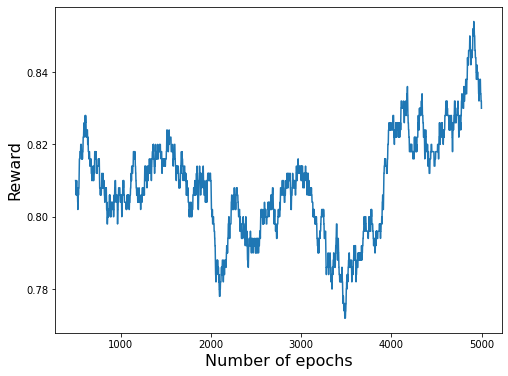

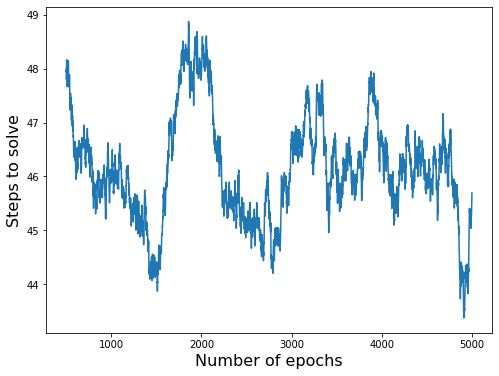

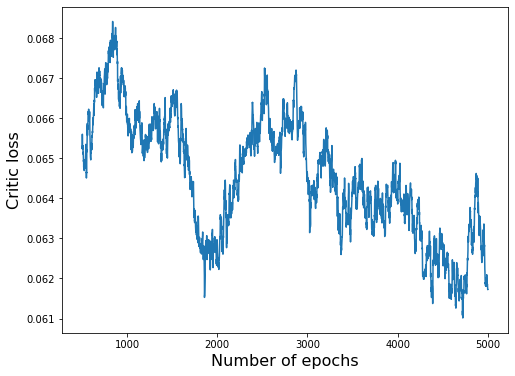

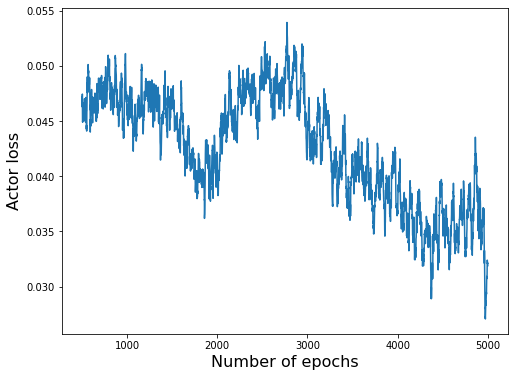

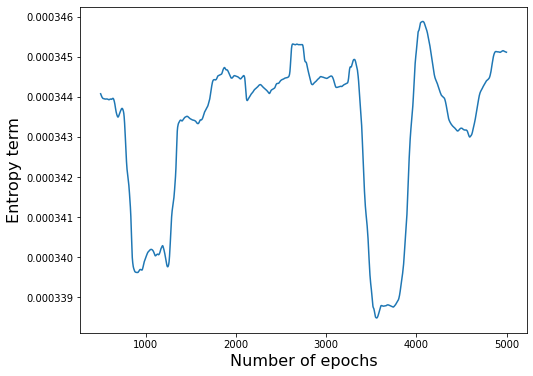

In [0]:
plot.plot_results(radam_results, moving_average=True, average_window=500)

In [0]:
HPs = dict(lr=5e-4, gamma=0.9, TD=True, twin=True, tau=0.3, n_steps=5, H=1e-3, radam=False)

if colab:
    HPs['device'] = 'cuda'
else:
    HPs['device'] = 'cpu'

# Relational Agent
agent = ActorCritic.BoxWorldA2C(action_space = 4, **HPs)

In [5]:
%%time
results = train.train_sandbox(agent, game_params, n_episodes = 10000,
                              max_steps=MAX_STEPS, return_agent=True, random_init=True)

Episode 10 - reward: 0.20 - steps to solve: 81.50
Episode 20 - reward: 0.00 - steps to solve: 100.00
Episode 30 - reward: 0.20 - steps to solve: 80.40
Episode 40 - reward: 0.00 - steps to solve: 100.00
Episode 50 - reward: 0.00 - steps to solve: 100.00
Episode 60 - reward: 0.00 - steps to solve: 100.00
Episode 70 - reward: 0.10 - steps to solve: 90.10
Episode 80 - reward: 0.00 - steps to solve: 100.00
Episode 90 - reward: 0.20 - steps to solve: 80.30
Episode 100 - reward: 0.00 - steps to solve: 100.00
Episode 110 - reward: 0.10 - steps to solve: 90.20
Episode 120 - reward: 0.20 - steps to solve: 80.50
Episode 130 - reward: 0.10 - steps to solve: 90.40
Episode 140 - reward: 0.10 - steps to solve: 90.20
Episode 150 - reward: 0.00 - steps to solve: 100.00
Episode 160 - reward: 0.10 - steps to solve: 90.10
Episode 170 - reward: 0.10 - steps to solve: 90.20
Episode 180 - reward: 0.00 - steps to solve: 100.00
Episode 190 - reward: 0.00 - steps to solve: 100.00
Episode 200 - reward: 0.10 - st

In [0]:
score, asymptotic_score, asymptotic_std, trained_agent, time_profile, losses, steps_to_solve = results

In [8]:
save = True
keywords = ['adam', 'relational','5by5', 'lr5e-3','TD(5)','sandbox',str(len(score))+"-episodes","100-steps"] # example

if colab and save:
    %cd ~
    parent_dir = "/content/gdrive/My Drive/Colab Notebooks/"
    save_dir  = "RelationalTrained/"
    %cd "{parent_dir}"
    !mkdir "{save_dir}"
    ID = utils.save_session(save_dir, keywords, game_params, HPs, score, steps_to_solve, losses)
    torch.save(trained_agent, save_dir+"agent_"+ID)
elif save:
    save_dir = 'Results/Sandbox/'
    ID = utils.save_session(save_dir, keywords, game_params, HPs, score, steps_to_solve, losses)
    torch.save(trained_agent, save_dir+"agent_"+ID)
else:
    print("Nothing saved")
    pass

/root
/content/gdrive/My Drive/Colab Notebooks
mkdir: cannot create directory ‘RelationalTrained/’: File exists
Save at RelationalTrained/S_adam_relational_5by5_lr5e-3_TD(5)_sandbox_10000-episodes_100-steps_DWPP


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type BoxWorldActor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type BoxWorldNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Convolution. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RelationalModule. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/

Average time for playing one episode: 0.46 s
Average time for updating the agent: 0.54 s
Asymptotic score: 0.699 +/- 0.459


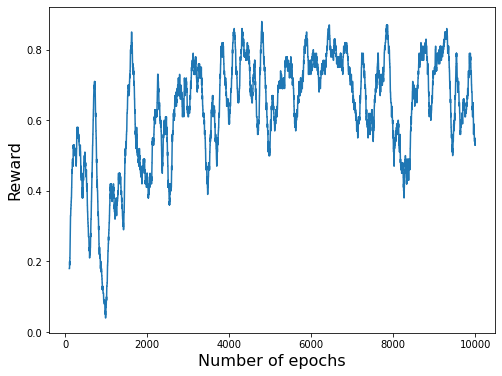

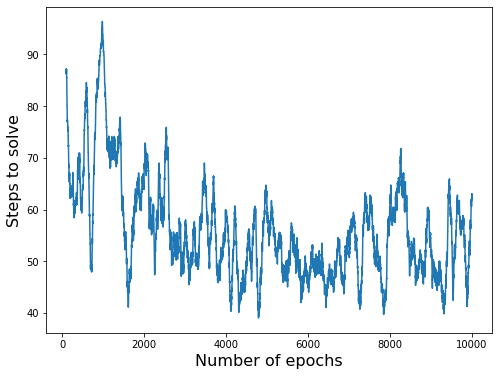

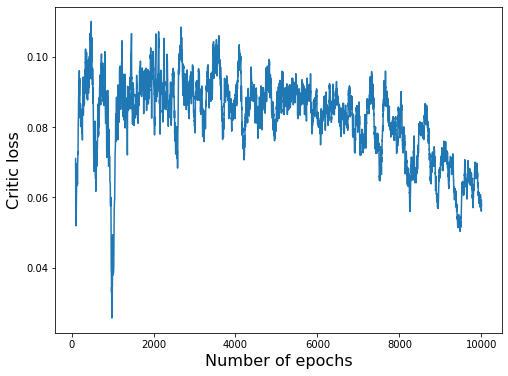

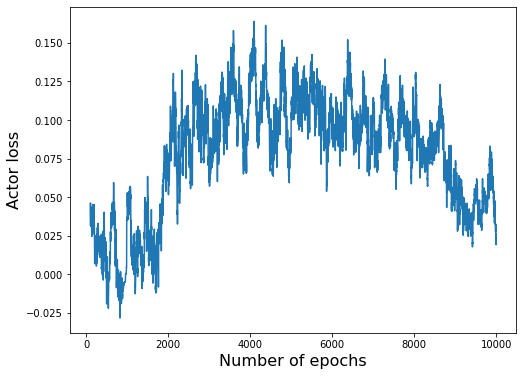

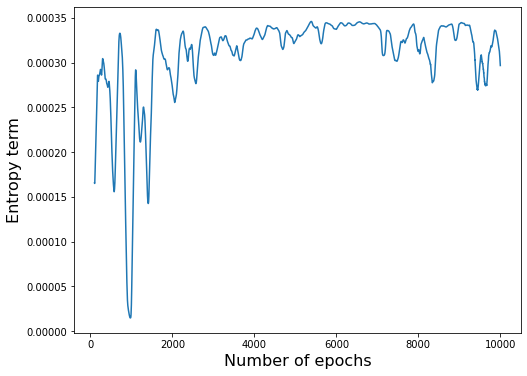

In [0]:
plot.plot_results(results, moving_average=True)

In [0]:
plot.compare_results(radam_results, results, 'RAdam relational', 'Adam relational', moving_average=True)

# Embeddied State Representation

In [0]:
# Variable parameters
X = 10
Y = 10
initial = [0,0]
goal = [6,7]

game_params = dict(x=X, y=Y, initial=initial, goal=goal, max_steps=100, greyscale_state=True)

## Scripted critic

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.distributions import Categorical

from RelationalModule.AC_networks import ControlCritic #custom module

debug = False 

class CriticAgentTD():
    """
    Advantage Actor-Critic RL agent for BoxWorld environment described in the paper
    Relational Deep Reinforcement Learning.
    
    Notes
    -----
    * Always uses 2 separate networks for the critic,one that learns from new experience 
      (student/critic) and the other one (critic_target/teacher)that is more conservative 
      and whose weights are updated through an exponential moving average of the weights 
      of the critic, i.e.
          target.params = (1-tau)*target.params + tau* critic.params
    * In the case of Monte Carlo estimation the critic_target is never used
    * Possible to use twin networks for the critic and the critic target for improved 
      stability. Critic target is used for updates of both the actor and the critic and
      its output is the minimum between the predictions of its two internal networks.
      
    """ 
    
    def __init__(self, lr, gamma, TD=True, twin=False, tau = 1., 
                 H=1e-2, n_steps = 1, device='cpu', **box_net_args):
        
        self.gamma = gamma
        self.lr = lr
        
        self.TD = TD
        self.twin = twin 
        self.tau = tau
        self.H = H
        self.n_steps = n_steps
        
        self.critic = ControlCritic(twin, **box_net_args)
        
        if self.TD:
            self.critic_trg = ControlCritic(twin, target=True, **box_net_args)

            # Init critic target identical to critic
            for trg_params, params in zip(self.critic_trg.parameters(), self.critic.parameters()):
                trg_params.data.copy_(params.data)
            
        self.critic_optim = torch.optim.Adam(self.critic.parameters(), lr=lr)
        
        self.device = device 
        self.critic.to(self.device)
        if self.TD:
            self.critic_trg.to(self.device)
        
        if debug:
            print("="*10 +" A2C HyperParameters "+"="*10)
            print("Discount factor: ", self.gamma)
            print("Learning rate: ", self.lr)
            print("Temporal Difference learning: ", self.TD)
            print("Twin networks: ", self.twin)
            print("Update critic target factor: ", self.tau)
            if self.TD:
                print("n_steps for TD: ", self.n_steps)
            print("Device used: ", self.device)
            print("\n\n"+"="*10 +" A2C Architecture "+"="*10)
            print("Critic architecture: \n",self.critic)
            print("Critic target architecture: ")
            if self.TD:
                print(self.critic_trg)
            else:
                print("Not used")
    
    def update_TD(self, rewards, states, done, bootstrap=None):   
        
        ### Compute n-steps rewards, states, discount factors and done mask ###
        
        n_step_rewards = self.compute_n_step_rewards(rewards)
        if debug:
            print("n_step_rewards.shape: ", n_step_rewards.shape)
            print("rewards.shape: ", rewards.shape)
            print("n_step_rewards: ", n_step_rewards)
            print("rewards: ", rewards)
            print("bootstrap: ", bootstrap)
                
        if bootstrap is not None:
            done[bootstrap] = False 
        if debug:
            print("done.shape: (before n_steps)", done.shape)
            print("done: (before n_steps)", done)
        
        old_states = torch.tensor(states[:-1].astype(int)).to(self.device)

        new_states, Gamma_V, done = self.compute_n_step_states(states, done)
        new_states = torch.tensor(new_states.astype(int)).to(self.device)

        if debug:
            print("done.shape: (after n_steps)", done.shape)
            print("Gamma_V.shape: ", Gamma_V.shape)
            print("done: (after n_steps)", done)
            print("Gamma_V: ", Gamma_V)
            print("old_states.shape: ", old_states.shape)
            print("new_states.shape: ", new_states.shape)
            
        ### Wrap variables into tensors ###
        
        done = torch.LongTensor(done.astype(int)).to(self.device)
    
        n_step_rewards = torch.tensor(n_step_rewards).float().to(self.device)
        Gamma_V = torch.tensor(Gamma_V).float().to(self.device)
        
        ### Update critic and then actor ###
        critic_loss = self.update_critic_TD(n_step_rewards, new_states, old_states, done, Gamma_V)
        #actor_loss, entropy = self.update_actor_TD(n_step_rewards, log_probs, distributions, new_states, old_states, done, Gamma_V)
        
        return critic_loss#, actor_loss, entropy
    
    def update_critic_TD(self, n_step_rewards, new_states, old_states, done, Gamma_V):
        
        # Compute loss 
        if debug: print("Updating critic...")
        with torch.no_grad():
            V_trg = self.critic_trg(new_states).squeeze()
            if debug:
                print("V_trg.shape (after critic): ", V_trg.shape)
            V_trg = (1-done)*Gamma_V*V_trg + n_step_rewards
            if debug:
                print("V_trg.shape (after sum): ", V_trg.shape)
            V_trg = V_trg.squeeze()
            if debug:
                print("V_trg.shape (after squeeze): ", V_trg.shape)
                print("V_trg.shape (after squeeze): ", V_trg)
            
        if self.twin:
            V1, V2 = self.critic(old_states)
            if debug:
                print("V1.shape: ", V1.squeeze().shape)
                print("V1: ", V1)
            loss1 = 0.5*F.mse_loss(V1.squeeze(), V_trg)
            loss2 = 0.5*F.mse_loss(V2.squeeze(), V_trg)
            loss = loss1 + loss2
        else:
            V = self.critic(old_states).squeeze()
            if debug: 
                print("V.shape: ",  V.shape)
                print("V: ",  V)
            loss = F.mse_loss(V, V_trg)
        
        # Backpropagate and update
        
        self.critic_optim.zero_grad()
        loss.backward()
        self.critic_optim.step()
        
        # Update critic_target: (1-tau)*old + tau*new
        
        for trg_params, params in zip(self.critic_trg.parameters(), self.critic.parameters()):
                trg_params.data.copy_((1.-self.tau)*trg_params.data + self.tau*params.data)
        
        return loss.item()
    
    def compute_n_step_rewards(self, rewards):
        """
        Computes n-steps discounted reward padding with zeros the last elements of the trajectory.
        This means that the rewards considered are AT MOST n, but can be less for the last n-1 elements.
        """
        T = len(rewards)
        
        # concatenate n_steps zeros to the rewards -> they do not change the cumsum
        r = np.concatenate((rewards,[0 for _ in range(self.n_steps)])) 
        
        Gamma = np.array([self.gamma**i for i in range(r.shape[0])])
        
        # reverse everything to use cumsum in right order, then reverse again
        Gt = np.cumsum(r[::-1]*Gamma[::-1])[::-1]
        
        G_nstep = Gt[:T] - Gt[self.n_steps:] # compute n-steps discounted return
        
        Gamma = Gamma[:T]
        
        assert len(G_nstep) == T, "Something went wrong computing n-steps reward"
        
        n_steps_r = G_nstep / Gamma
        
        return n_steps_r
    
    def compute_n_step_states(self, states, done):
        """
        Computes n-steps target states (to be used by the critic as target values together with the
        n-steps discounted reward). For last n-1 elements the target state is the last one available.
        Adjusts also the `done` mask used for disabling the bootstrapping in the case of terminal states
        and returns Gamma_V, that are the discount factors for the target state-values, since they are 
        n-steps away (except for the last n-1 states, whose discount is adjusted accordingly).
        
        Return
        ------
        new_states, Gamma_V, done: arrays with first dimension = len(states)-1
        """
        
        # Compute indexes for (at most) n-step away states 
        
        n_step_idx = np.arange(len(states)-1) + self.n_steps
        diff = n_step_idx - len(states) + 1
        mask = (diff > 0)
        n_step_idx[mask] = len(states) - 1
        
        # Compute new states
        
        new_states = states[n_step_idx]
        
        # Compute discount factors
        
        pw = np.array([self.n_steps for _ in range(len(new_states))])
        pw[mask] = self.n_steps - diff[mask]
        Gamma_V = self.gamma**pw
        
        # Adjust done mask
        
        mask = (diff >= 0)
        done[mask] = done[-1]
        
        return new_states, Gamma_V, done


In [0]:
def play_optimal(env):
    state = env.reset(random_init = True)
    
    rewards = []
    done = []
    states = [state]
    bootstrap = []
    
    while True:
        action = env.get_optimal_action()
        
        new_state, reward, terminal, info = env.step(action) 
        states.append(new_state)
        rewards.append(reward)
        done.append(terminal)
        
        if terminal is True and 'TimeLimit.truncated' in info:
            bootstrap.append(True)
        else:
            bootstrap.append(False) 
            
        if terminal:
            break
            
        state = new_state
    
    return np.array(rewards), np.array(states), np.array(done), np.array(bootstrap)

In [0]:
reload(test_env)

In [0]:
def train_critic_TD(HPs, n_episodes = 100):
    
    # Create environment
    env = test_env.Sandbox(10, 10, [0,0], [9,9], max_steps=50)
    
    critic = CriticAgentTD(**HPs)
    
    losses = []
    for e in range(n_episodes):
        rewards, states, done, bootstrap = play_optimal(env)
        loss = critic.update_TD(rewards, states, done, bootstrap)
        losses.append(loss)
        
        if (e+1)%10 == 0:
            print("Episode %d - loss: %.4f"%(e+1, np.mean(losses[-10:])))

    return critic, losses

In [0]:
HPs = dict(lr=0.0005, gamma=0.99, TD=True, twin=True, tau=0.01, n_steps=1,
               H=1., vocab_size = 4, n_dim=3, n_features=16, n_heads=4, linear_size=12)

In [0]:
critic, losses = train_critic_TD(HPs, 5000)

In [0]:
x = "Number of episodes"
y = "Squared error of the prediction [log]"
t = "Critic trained through optimal policy and TD"
plot_loss(losses, x, y, t, ylog=True)

In [0]:
import copy
MAP_SIZE = 10 + 2 # because of the border
goal = (9+1,9+1) # because of the border
state = np.full([MAP_SIZE,MAP_SIZE], 0)
values = np.full([MAP_SIZE,MAP_SIZE], 0).astype(float)
state[goal] = 2

for s in range(MAP_SIZE**2):
    x, y = s//MAP_SIZE, s%MAP_SIZE
    new_state = copy.deepcopy(state)
    new_state[x,y] = 1
    new_state = torch.LongTensor(new_state).unsqueeze(0)
    with torch.no_grad():
        V1, V2 = critic.critic(new_state)
        V = torch.min(V1,V2)
    values[x,y] = V.squeeze().numpy()

In [0]:
def get_real_value_map(env, gamma):
    distances = np.zeros((env.boundary[0], env.boundary[1] ))
    for x in range(env.boundary[0]):
        for y in range(env.boundary[1]):
            d = env.dist_to_goal([x,y])
            distances[x,y] = d
    distances = distances.flatten() -1
    real_values = gamma**distances
    real_values[-1] = 1
    return real_values.reshape(env.boundary[0], env.boundary[1])

In [0]:
def value_map(critic, env):
    MAP_SIZE = env.boundary[0] 
    goal = (env.goal[0]+1, env.goal[1]+1)
    gamma = critic.gamma
    
    state = np.full([MAP_SIZE+2,MAP_SIZE+2], 0)
    values = np.full([MAP_SIZE,MAP_SIZE], 0).astype(float)
    state[goal] = 2
    # adding borders
    state[0,:] = 3
    state[-1,:] = 3
    state[:,0] = 3
    state[:,-1] = 3
    
    for s in range(MAP_SIZE**2):
        x, y = s//MAP_SIZE, s%MAP_SIZE
        new_state = copy.deepcopy(state)
        new_state[x+1,y+1] = 1
        new_state = torch.LongTensor(new_state).unsqueeze(0)
        with torch.no_grad():
            V1, V2 = critic.critic(new_state)
            V = torch.min(V1,V2)
        values[x,y] = V.squeeze().numpy()
    
    plt.figure(figsize=(15,6))

    plt.subplot(121)
    values[-1,-1] = 1
    plt.imshow(values)
    plt.xticks([])
    plt.yticks([])
    plt.title("Value map", fontsize=16)
    plt.colorbar()
    
    real_values = get_real_value_map(env, gamma)
    plt.subplot(122)
    plt.imshow(real_values)
    plt.xticks([])
    plt.yticks([])
    plt.title("Real values", fontsize=16)
    plt.colorbar()
    
    plt.figure(figsize=(7,6))
    diff = values-real_values
    diff[-1,-1] = 0
    plt.imshow(diff)
    #plt.imshow(real_values)
    plt.xticks([])
    plt.yticks([])
    plt.title("Difference from real value", fontsize=16)
    plt.colorbar()
    

In [0]:
env = test_env.Sandbox(10, 10, [0,0], [9,9], max_steps=50)
value_map(critic, env)

## Scripted actor

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.distributions import Categorical

from RelationalModule.AC_networks import ControlActor

debug = False

class ActorAgentTD():
    """
    Advantage Actor-Critic RL agent for BoxWorld environment described in the paper
    Relational Deep Reinforcement Learning.
    
    Notes
    -----
    * Always uses 2 separate networks for the critic,one that learns from new experience 
      (student/critic) and the other one (critic_target/teacher)that is more conservative 
      and whose weights are updated through an exponential moving average of the weights 
      of the critic, i.e.
          target.params = (1-tau)*target.params + tau* critic.params
    * In the case of Monte Carlo estimation the critic_target is never used
    * Possible to use twin networks for the critic and the critic target for improved 
      stability. Critic target is used for updates of both the actor and the critic and
      its output is the minimum between the predictions of its two internal networks.
      
    """ 
    
    def __init__(self, action_space, lr, gamma, TD=True, twin=False, tau = 1., 
                 H=1e-2, n_steps = 1, device='cpu', **box_net_args):
        """
        Parameters
        ----------
        action_space: int
            Number of (discrete) possible actions to take
        lr: float in [0,1]
            Learning rate
        gamma: float in [0,1]
            Discount factor
        TD: bool (default=True)
            If True, uses Temporal Difference for the critic's estimates
            Otherwise uses Monte Carlo estimation
        twin: bool (default=False)
            Enables twin networks both for critic and critic_target
        tau: float in [0,1] (default = 1.)
            Regulates how fast the critic_target gets updates, i.e. what percentage of the weights
            inherits from the critic. If tau=1., critic and critic_target are identical 
            at every step, if tau=0. critic_target is unchangable. 
            As a default this feature is disabled setting tau = 1, but if one wants to use it a good
            empirical value is 0.005.
        H: float (default 1e-2)
            Entropy multiplicative factor in actor's loss
        n_steps: int (default=1)
            Number of steps considered in TD update
        device: str in {'cpu','cuda'}
            Select if training agent with cpu or gpu. 
            FIXME: At the moment is gpu is present, it MUST use the gpu.
        **box_net_args: dict (optional)
            Dictionary of {'key':value} pairs valid for BoxWorldNet.
            Valid keys:
                in_channels: int (default 3)
                    Number of channels of the input image (e.g. 3 for RGB)
                n_kernels: int (default 24)
                    Number of features extracted for each pixel
                vocab_size: int (default 116)
                    Range of integer values of the raw pixels
                n_dim: int (default 3)
                    Embedding dimension for each pixel channel (1 channel for greyscale, 
                    3 for RGB)
                n_features: int (default 256)
                    Number of linearly projected features after positional encoding.
                    This is the number of features used during the Multi-Headed Attention
                    (MHA) blocks
                n_heads: int (default 4)
                    Number of heades in each MHA block
                n_attn_modules: int (default 2)
                    Number of MHA blocks
                n_linears: int (default 4)
                    Number of fully-connected layers after the FeaturewiseMaxPool layer
        """
        
        self.gamma = gamma
        self.lr = lr
        
        self.n_actions = action_space
        self.TD = TD
        self.twin = twin 
        self.tau = tau
        self.H = H
        self.n_steps = n_steps
        
        self.actor = ControlActor(action_space, **box_net_args)
       

        self.actor_optim = torch.optim.Adam(self.actor.parameters(), lr=lr)
            
     
        self.device = device 
        self.actor.to(self.device) 
        
    def get_action(self, state, return_log=False):
        log_probs = self.forward(state)
        dist = torch.exp(log_probs)
        probs = Categorical(dist)
        action =  probs.sample().item()
        if return_log:
            return action, log_probs.view(-1)[action], dist
        else:
            return action
    
    def forward(self, state):
        """
        Makes a tensor out of a numpy array state and then forward
        it with the actor network.
        
        Parameters
        ----------
        state: array of int
            Shape (episode_len, in_channels, lin_size, lin_size)
            Or    (in_channels, lin_size, lin_size)
        """
        state = torch.from_numpy(state.astype(int)).to(self.device)
        log_probs = self.actor(state)
        return log_probs
    
    def critic(self, state, env):
        """Implements optimal critic given the sandbox environment."""
        AGENT_COLOR = 1
        distances = []
        for s in state:
            #print("s: ", s)
            shape = s.shape
            #print("shape: ", shape)
            s = s.numpy().reshape(shape[1], shape[2])
            x, y = np.where(s==AGENT_COLOR)
            #print("x and y: ", x, y)
            s_decoded = [x, y]
            #print("s_decoded: ", s_decoded)
            #print("\n\tState %d decoded in (%d, %d)"%(s, s_decoded[0], s_decoded[1]))
            d = env.dist_to_goal(s_decoded)
            #print("\tGoal in (%d,%d)"%(env.goal[0], env.goal[1]))
            #print("\tDistance from goal: ", d)
            distances.append(d)
        distances = np.array(distances) -1
        #print("distances.shape: ", distances.shape)
        #print("Distances: ", distances)
        #print("gamma*dist: ", (self.gamma**distances).shape)
        values = torch.tensor(self.gamma**distances).float()
        
        #print("Values: ", values,'\n')
        return values
    
    def update_TD(self, env, rewards, log_probs, distributions, states, done, bootstrap=None):   
        
        ### Compute n-steps rewards, states, discount factors and done mask ###
        
        n_step_rewards = self.compute_n_step_rewards(rewards)
        if debug:
            print("n_step_rewards.shape: ", n_step_rewards.shape)
            print("rewards.shape: ", rewards.shape)
            print("n_step_rewards: ", n_step_rewards)
            print("rewards: ", rewards)
            #print("bootstrap: ", bootstrap)
                
        if bootstrap is not None:
            done[bootstrap] = False 
        #if debug:
            #print("done.shape: (before n_steps)", done.shape)
            #print("done: (before n_steps)", done)
        
        old_states = torch.tensor(states[:-1].astype(int)).to(self.device)

        new_states, Gamma_V, done = self.compute_n_step_states(states, done)
        new_states = torch.tensor(new_states.astype(int)).to(self.device)

        if debug:
            print("done.shape: (after n_steps)", done.shape)
            print("Gamma_V.shape: ", Gamma_V.shape)
            print("done: (after n_steps)", done)
            print("Gamma_V: ", Gamma_V)
            print("old_states.shape: ", old_states.shape)
            print("new_states.shape: ", new_states.shape)
            
        ### Wrap variables into tensors ###
        
        done = torch.LongTensor(done.astype(int)).to(self.device)
        #if debug: print("log_probs: ", log_probs)
        log_probs = torch.stack(log_probs).to(self.device)
        #if debug: print("log_probs: ", log_probs)
        distributions = torch.stack(distributions, axis=1).to(self.device)
        # Regularize terms with 0 probability (if that happens)
        mask = (distributions == 0).nonzero()
        distributions[:,mask] = 1e-5
        
        n_step_rewards = torch.tensor(n_step_rewards).float().to(self.device)
        Gamma_V = torch.tensor(Gamma_V).float().to(self.device)
        
        ### Update critic and then actor ###
        #critic_loss = self.update_critic_TD(n_step_rewards, new_states, old_states, done, Gamma_V)
        actor_loss = self.update_actor_TD(env, n_step_rewards, log_probs, distributions, new_states, old_states, done, Gamma_V)
        
        return actor_loss
    

    def update_actor_TD(self, env, n_step_rewards, log_probs, distributions, new_states, old_states, done, Gamma_V):
        
        # Compute gradient 
        if debug: print("Updating actor...")
        with torch.no_grad():
            V_pred = self.critic(old_states, env).squeeze()
            V_trg = self.critic(new_states, env).squeeze()
            V_trg = (1-done)*Gamma_V*V_trg + n_step_rewards
            
        A = V_trg - V_pred
        policy_gradient = - log_probs*A
        if debug:
            print("V_trg.shape: ",V_trg.shape)
            print("V_trg: ", V_trg)
            print("V_pred.shape: ",V_pred.shape)
            print("V_pred: ", V_pred)
            print("A.shape: ", A.shape)
            print("A: ", A)
            print("policy_gradient.shape: ", policy_gradient.shape)
            print("policy_gradient: ", policy_gradient)
        policy_grad = torch.mean(policy_gradient)
        if debug: print("policy_grad: ", policy_grad)
        entropy = self.H*torch.mean(distributions*torch.log(distributions))
        loss = policy_grad + entropy
        if debug: print("Actor loss: ", loss)
        
        # Backpropagate and update
    
        self.actor_optim.zero_grad()
        loss.backward()
        self.actor_optim.step()
        
        return policy_grad.item()
    
    def compute_n_step_rewards(self, rewards):
        """
        Computes n-steps discounted reward padding with zeros the last elements of the trajectory.
        This means that the rewards considered are AT MOST n, but can be less for the last n-1 elements.
        """
        T = len(rewards)
        
        # concatenate n_steps zeros to the rewards -> they do not change the cumsum
        r = np.concatenate((rewards,[0 for _ in range(self.n_steps)])) 
        
        Gamma = np.array([self.gamma**i for i in range(r.shape[0])])
        
        # reverse everything to use cumsum in right order, then reverse again
        Gt = np.cumsum(r[::-1]*Gamma[::-1])[::-1]
        
        G_nstep = Gt[:T] - Gt[self.n_steps:] # compute n-steps discounted return
        
        Gamma = Gamma[:T]
        
        assert len(G_nstep) == T, "Something went wrong computing n-steps reward"
        
        n_steps_r = G_nstep / Gamma
        
        return n_steps_r
    
    def compute_n_step_states(self, states, done):
        """
        Computes n-steps target states (to be used by the critic as target values together with the
        n-steps discounted reward). For last n-1 elements the target state is the last one available.
        Adjusts also the `done` mask used for disabling the bootstrapping in the case of terminal states
        and returns Gamma_V, that are the discount factors for the target state-values, since they are 
        n-steps away (except for the last n-1 states, whose discount is adjusted accordingly).
        
        Return
        ------
        new_states, Gamma_V, done: arrays with first dimension = len(states)-1
        """
        
        # Compute indexes for (at most) n-step away states 
        
        n_step_idx = np.arange(len(states)-1) + self.n_steps
        diff = n_step_idx - len(states) + 1
        mask = (diff > 0)
        n_step_idx[mask] = len(states) - 1
        
        # Compute new states
        
        new_states = states[n_step_idx]
        
        # Compute discount factors
        
        pw = np.array([self.n_steps for _ in range(len(new_states))])
        pw[mask] = self.n_steps - diff[mask]
        Gamma_V = self.gamma**pw
        
        # Adjust done mask
        
        mask = (diff >= 0)
        done[mask] = done[-1]
        
        return new_states, Gamma_V, done
    

In [0]:
def play_episode(agent, env):
    # Reset environment (start of an episode)
    state = env.reset(random_init=True)
    
    states = [state]
    rewards = []
    log_probs = []
    distributions = []
    done = []
    bootstrap = []
    
        
        
    while True:
        action, log_prob, distr = agent.get_action(state, return_log=True)
        new_state, reward, terminal, info = env.step(action) # gym standard step's output
        

        states.append(new_state)
        rewards.append(reward)
        log_probs.append(log_prob)
        distributions.append(distr)
        done.append(terminal)
        
        if terminal is True and 'TimeLimit.truncated' in info:
            bootstrap.append(True)
        else:
            bootstrap.append(False) 
            
        if terminal:
            break
            
        state = new_state
       
    return  np.array(rewards), log_probs, distributions, np.array(states), np.array(done), np.array(bootstrap)

In [0]:
def train_actor_TD(actor, env, n_episodes = 100):
    losses = []
    performances = []
    steps_to_solve = []
    for e in range(n_episodes):
        rewards, log_probs, distributions, states, done, bootstrap = play_episode(actor, env)
        loss = actor.update_TD(env, rewards, log_probs, distributions, states, done, bootstrap)
        losses.append(loss)
        performances.append(rewards.sum())
        steps_to_solve.append(len(rewards))
        if (e+1)%10 == 0:
            print("Episode %d - reward: %.2f -  steps to solve: %.2f"%(e+1, np.mean(performances[-10:]), np.mean(steps_to_solve[-10:])))

    return actor, performances, losses, steps_to_solve

In [0]:
HPs = dict(lr=0.0003, gamma=0.99, TD=True, twin=True, tau=1., n_steps=1,
               H=1., vocab_size = 4, n_dim=3, n_features=64, n_heads=4, linear_size=7)

In [0]:
env = test_env.Sandbox(5, 5, [0,0], [4,4], max_steps=50)
action_space = 4
actor = ActorAgentTD(action_space, **HPs)

In [0]:
%%time
actor_TD, score, actor_loss_TD, steps_to_solve = train_actor_TD(actor, env, 1000)

In [0]:
x = "Number of episodes"
y = "Actor loss"
t = "Actor trained through optimal critic"
plot_loss(actor_loss_TD, x, y, t, ylog=False)

In [0]:
x = "Number of episodes"
y = "Total reward"
t = "Actor trained through optimal critic"
window = 500
moving_score =  np.array([np.mean(score[i:i+window]) for i in range(len(score)-window)])
plot_loss(moving_score, x, y, t, ylog=False)

In [0]:
from Utils import utils

In [0]:
%matplotlib notebook
utils.render(actor_TD, x=5, y=5, goal=[4,4])

In [0]:
%matplotlib inline

In [0]:
save = False
keywords = ['relational', 'sandbox',str(len(score))+"-episodes","100-steps"] # example

if colab and save:
    %cd ~
    parent_dir = "/content/gdrive/My Drive/Colab Notebooks/"
    save_dir  = "RelationalTrained/"
    %cd "{parent_dir}"
    !mkdir "{save_dir}"
    ID = utils.save_session(save_dir, keywords, game_params, HPs, score)
    torch.save(trained_agent, save_dir+"agent_"+ID)
elif save:
    save_dir = 'Results/Sandbox/'
    ID = utils.save_session(save_dir, keywords, game_params, HPs, score)
    torch.save(trained_agent, save_dir+"agent_"+ID)
else:
    print("Nothing saved")
    pass